# MASK ENERGY

In [3]:
import numpy
import h5py
import time
import os, sys
import random
from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [5]:
train_variables = 2
num_labels = train_variables

batch_size = 256
dropout = 0.2
learning_rate = 1e-3
DC_drop_value = dropout
IC_drop_value =dropout
connected_drop_value = dropout
min_energy = 5
max_energy = 100.
num_epochs = 280

filename = 'numu_flat_EZ_5_100_CC_uncleaned_280epochs_test'
save = True
save_folder_name = "output_plots/%s/"%(filename)
if save==True:
    if os.path.isdir(save_folder_name) != True:
        os.mkdir(save_folder_name)
        
use_old_weights = True
load_model_name = "numu_flat_EZ_5_100_CC_uncleaned_cleanedpulsesonly_3600kevents_280epochs_model.hdf5"
use_old_reco = False

##Getting files for testing
make_file = False

import glob
file_name_base = "NuMu_140000_level2.zst_uncleaned_cleanedpulsesonly_lt100_CC_flat_95bins_36034evtperbinall_file0?.transformed.hdf5"
#file_name_base = "NuMu_140000_level2.zst_cleaned_lt100_CC_flat_95bins_36034evtperbinall_file0?.transformedinputoutput.hdf5"
file_names = sorted(glob.glob(file_name_base))

split_file_name = file_name_base.split('_')
new_name = split_file_name[0]
for name in range(1,len(split_file_name)-1):
    new_name = new_name + "_" + split_file_name[name]
new_name += ".testonly.hdf5"
output_file =  new_name

In [6]:
file = file_names[0]
f = h5py.File(file, 'r')
X_train_DC = f['X_train_DC'][:]
X_train_IC = f['X_train_IC'][:]
f.close()
del f
print("Train Data DC", X_train_DC.shape)
print("Train Data IC", X_train_IC.shape)

Train Data DC (352104, 8, 60, 5)
Train Data IC (352104, 7, 60, 5)


In [7]:
### Build The Network ##
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import initializers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


## MIRCO NETWORK ##

# DEEP CORE #
#print("Train Data DC", X_train_DC.shape)
strings = X_train_DC.shape[1]
dom_per_string = X_train_DC.shape[2]
dom_variables = X_train_DC.shape[3]

# Conv DC + batch normalization, later dropout and maxpooling
input_DC = Input(shape=(strings, dom_per_string, dom_variables))

conv1_DC = Conv2D(100,kernel_size=(strings,5),padding='same',activation='tanh')(input_DC)
batch1_DC = BatchNormalization()(conv1_DC)
pool1_DC = MaxPooling2D(pool_size=(1,2))(batch1_DC)
drop1_DC = Dropout(DC_drop_value)(pool1_DC)

conv2_DC = Conv2D(100,kernel_size=(strings,7),padding='same',activation='relu')(drop1_DC)
batch2_DC = BatchNormalization()(conv2_DC)
drop2_DC = Dropout(DC_drop_value)(batch2_DC)

conv3_DC = Conv2D(100,kernel_size=(strings,7),padding='same',activation='relu')(drop2_DC)
batch3_DC = BatchNormalization()(conv3_DC)
drop3_DC = Dropout(DC_drop_value)(batch3_DC)

conv4_DC = Conv2D(100,kernel_size=(strings,3),padding='valid',activation='relu')(drop3_DC)
batch4_DC = BatchNormalization()(conv4_DC)
pool4_DC = MaxPooling2D(pool_size=(1,2))(batch4_DC)
drop4_DC = Dropout(DC_drop_value)(pool4_DC)

conv5_DC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop4_DC)
batch5_DC = BatchNormalization()(conv5_DC)
drop5_DC = Dropout(DC_drop_value)(batch5_DC)

conv6_DC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop5_DC)
batch6_DC = BatchNormalization()(conv6_DC)
drop6_DC = Dropout(DC_drop_value)(batch6_DC)

conv7_DC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop6_DC)
batch7_DC = BatchNormalization()(conv7_DC)
drop7_DC = Dropout(DC_drop_value)(batch7_DC)

conv8_DC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop7_DC)
batch8_DC = BatchNormalization()(conv8_DC)
drop8_DC = Dropout(DC_drop_value)(batch8_DC)

flat_DC = Flatten()(drop8_DC)


# ICECUBE NEAR DEEPCORE #
#print("Train Data IC", X_train_IC.shape)
strings_IC = X_train_IC.shape[1]
dom_per_string_IC = X_train_IC.shape[2]
dom_variables_IC = X_train_IC.shape[3]

# Conv DC + batch normalization, later dropout and maxpooling
input_IC = Input(shape=(strings_IC, dom_per_string_IC, dom_variables_IC))

conv1_IC = Conv2D(100,kernel_size=(strings_IC,5),padding='same',activation='tanh')(input_IC)
batch1_IC = BatchNormalization()(conv1_IC)
pool1_IC = MaxPooling2D(pool_size=(1,2))(batch1_IC)
drop1_IC = Dropout(IC_drop_value)(pool1_IC)

conv2_IC = Conv2D(100,kernel_size=(strings_IC,7),padding='same',activation='relu')(drop1_IC)
batch2_IC = BatchNormalization()(conv2_IC)
drop2_IC = Dropout(IC_drop_value)(batch2_IC)

conv3_IC = Conv2D(100,kernel_size=(strings_IC,7),padding='same',activation='relu')(drop2_IC)
batch3_IC = BatchNormalization()(conv3_IC)
drop3_IC = Dropout(IC_drop_value)(batch3_IC)

conv4_IC = Conv2D(100,kernel_size=(strings_IC,3),padding='valid',activation='relu')(drop3_IC)
batch4_IC = BatchNormalization()(conv4_IC)
pool4_IC = MaxPooling2D(pool_size=(1,2))(batch4_IC)
drop4_IC = Dropout(IC_drop_value)(pool4_IC)

conv5_IC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop4_IC)
batch5_IC = BatchNormalization()(conv5_IC)
drop5_IC = Dropout(IC_drop_value)(batch5_IC)

conv6_IC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop5_IC)
batch6_IC = BatchNormalization()(conv6_IC)
drop6_IC = Dropout(IC_drop_value)(batch6_IC)

conv7_IC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop6_IC)
batch7_IC = BatchNormalization()(conv7_IC)
drop7_IC = Dropout(IC_drop_value)(batch7_IC)

conv8_IC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop7_IC)
batch8_IC = BatchNormalization()(conv8_IC)
drop8_IC = Dropout(IC_drop_value)(batch8_IC)

flat_IC = Flatten()(drop8_IC)


# PUT TOGETHER #
concatted = concatenate([flat_DC, flat_IC])

full1 = Dense(300,activation='relu')(concatted)
batch1_full = BatchNormalization()(full1)
dropf = Dropout(connected_drop_value)(batch1_full)

output = Dense(num_labels,activation='linear')(dropf)
model_DC = Model(inputs=[input_DC,input_IC],outputs=output)


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model_DC.load_weights(load_model_name)

In [9]:
# WRITE OWN LOSS FOR MORE THAN ONE REGRESSION OUTPUT
from keras.losses import mean_squared_error
from keras.losses import mean_squared_logarithmic_error
from keras.losses import logcosh

def EnergyLoss(y_truth,y_predicted):
    #return mean_squared_logarithmic_error(y_truth[:,0],y_predicted[:,0]) #/120.
    return mean_squared_error(y_truth[:,0],y_predicted[:,0])

def ZenithLoss(y_truth,y_predicted):
    #return logcosh(y_truth[:,1],y_predicted[:,1])
    return mean_squared_error(y_truth[:,1],y_predicted[:,1])

def TrackLoss(y_truth,y_predicted):
    return mean_squared_logarithmic_error(y_truth[:,2],y_predicted[:,2])/100.

## Compile ##
if num_labels == 3:
    def CustomLoss(y_truth,y_predicted):
        energy_loss = EnergyLoss(y_truth,y_predicted)
        zenith_loss = ZenithLoss(y_truth,y_predicted)
        track_loss = TrackLoss(y_truth,y_predicted)
        return energy_loss + zenith_loss + track_loss

    model_DC.compile(loss=CustomLoss,
              optimizer=Adam(lr=learning_rate),
              metrics=[EnergyLoss,ZenithLoss,TrackLoss])

elif num_labels == 2:
    def CustomLoss(y_truth,y_predicted):
        energy_loss = EnergyLoss(y_truth,y_predicted)
        zenith_loss = ZenithLoss(y_truth,y_predicted)
        return energy_loss + zenith_loss

    model_DC.compile(loss=CustomLoss,
              optimizer=Adam(lr=learning_rate),
              metrics=[EnergyLoss,ZenithLoss])
else:
    def CustomLoss(y_truth,y_predicted):
        energy_loss = EnergyLoss(y_truth,y_predicted)
        return energy_loss

    model_DC.compile(loss=EnergyLoss,
                optimizer=Adam(lr=learning_rate),
                metrics=[EnergyLoss])


In [10]:
if make_file:
    
    print("Using %i files with names like %s"%(len(file_names), file_names[0]))

    # Put all the test sets together
    Y_test_use = None
    X_test_DC_use = None
    X_test_IC_use = None

    for file in file_names:
        f = h5py.File(file, 'r')
        Y_test = f['Y_test'][:]
        X_test_DC = f['X_test_DC'][:]
        X_test_IC = f['X_test_IC'][:]
        f.close()
        del f

        if Y_test_use is None:
            Y_test_use = Y_test
            X_test_DC_use = X_test_DC
            X_test_IC_use = X_test_IC
        else:
            Y_test_use = numpy.concatenate((Y_test_use, Y_test))
            X_test_DC_use = numpy.concatenate((X_test_DC_use, X_test_DC))
            X_test_IC_use = numpy.concatenate((X_test_IC_use, X_test_IC))
    print(Y_test_use.shape)
    
    save_output_file = True

    if save_output_file:

        print("Saving output file: %s"%output_file)
        f = h5py.File(output_file, "w")
        f.create_dataset("Y_test", data=Y_test_use)
        f.create_dataset("X_test_DC", data=X_test_DC_use)
        f.create_dataset("X_test_IC", data=X_test_IC_use)
        f.close()
        
else:
    print("Using %s"%output_file)
    file = output_file
    f = h5py.File(file, 'r')
    Y_test = f['Y_test'][:]
    X_test_DC = f['X_test_DC'][:]
    X_test_IC = f['X_test_IC'][:]
    f.close
    del f
    
    print(X_test_DC.shape,X_test_IC.shape)

Using NuMu_140000_level2.zst_uncleaned_cleanedpulsesonly_lt100_CC_flat_95bins_36034evtperbinall.testonly.hdf5
(342328, 8, 60, 5) (342328, 7, 60, 5)


In [11]:
t0 = time.time()
Y_test_predicted = model_DC.predict([X_test_DC,X_test_IC])
t1 = time.time()
print("This took me %f seconds for %i events"%(((t1-t0)),Y_test_predicted.shape[0]))

This took me 107.176234 seconds for 342328 events


In [12]:
from PlottingFunctions import plot_single_resolution
from PlottingFunctions import plot_2D_prediction
from PlottingFunctions import plot_history
from PlottingFunctions import plot_bin_slices

In [13]:
def plot_bin_slices(truth, nn_reco, true_energy = None, \
                       min_energy = 0., max_energy = 100., \
                       use_fraction = False, use_old_reco = False, old_reco=None,\
                       bins=10,min_val=0.,max_val=60.,\
                       save=False,savefolder=None,\
                       variable="Energy",units="GeV"):
    """Plots different variable slices vs each other (systematic set arrays)
    Receives:
        truth= array with truth labels
                (contents = [energy], shape = number of events)
        nn_reco = array that has NN predicted reco results
                    (contents = [energy], shape = number of events)
        use_fraction = bool, use fractional resolution instead of absolute, where (reco - truth)/truth
        use_old_reco = bool, True if you want to compare to another reconstruction (like pegleg)
        old_reco = optional, array of pegleg labels
                (contents = [energy], shape = number of events)
        bins = integer number of data points you want (range/bins = width)
        min_val = minimum value for variable to start cut at (default = 0.)
        max_val = maximum value for variable to end cut at (default = 60.)
    Returns:
        Scatter plot with energy values on x axis (median of bin width)
        y axis has median of resolution with error bars containing 68% of resolution
    """
    if use_fraction:
        resolution = ((nn_reco-truth)/truth) # in fraction
    else:
        resolution = (nn_reco-truth)

    percentile_in_peak = 68.27

    left_tail_percentile  = (100.-percentile_in_peak)/2
    right_tail_percentile = 100.-left_tail_percentile
    
    if true_energy is None:
        variable_ranges  = numpy.linspace(min_val,max_val, num=bins)
    else:
        variable_ranges  = numpy.linspace(min_energy,max_energy, num=bins)
    
    variable_centers = (variable_ranges[1:] + variable_ranges[:-1])/2.

    medians  = numpy.zeros(len(variable_centers))
    err_from = numpy.zeros(len(variable_centers))
    err_to   = numpy.zeros(len(variable_centers))

    if use_old_reco:
        if use_fraction:
            resolution_reco = ((old_reco-truth)/truth)
        else:
            resolution_reco = (old_reco-truth)
        medians_reco  = numpy.zeros(len(variable_centers))
        err_from_reco = numpy.zeros(len(variable_centers))
        err_to_reco   = numpy.zeros(len(variable_centers))
    
    for i in range(len(variable_ranges)-1):
        var_from = variable_ranges[i]
        var_to   = variable_ranges[i+1]
        
        if true_energy is None:
            cut = (truth >= var_from) & (truth < var_to)
        else:
            cut = (true_energy*max_energy >= var_from) & (true_energy*max_energy < var_to)

        lower_lim = numpy.percentile(resolution[cut], left_tail_percentile)
        upper_lim = numpy.percentile(resolution[cut], right_tail_percentile)
        median = numpy.percentile(resolution[cut], 50.)
        
        medians[i] = median
        err_from[i] = lower_lim
        err_to[i] = upper_lim
        
        if use_old_reco:
            lower_lim_reco = numpy.percentile(resolution_reco[cut], left_tail_percentile)
            upper_lim_reco = numpy.percentile(resolution_reco[cut], right_tail_percentile)
            median_reco = numpy.percentile(resolution_reco[cut], 50.)

            medians_reco[i] = median_reco
            err_from_reco[i] = lower_lim_reco
            err_to_reco[i] = upper_lim_reco

    plt.figure(figsize=(10,7))
    plt.errorbar(variable_centers, medians, yerr=[medians-err_from, err_to-medians], xerr=[ variable_centers-variable_ranges[:-1], variable_ranges[1:]-variable_centers ], capsize=5.0, fmt='o',label="NN Reco")
    if use_old_reco:
        plt.errorbar(variable_centers, medians_reco, yerr=[medians_reco-err_from_reco, err_to_reco-medians_reco], xerr=[ variable_centers-variable_ranges[:-1], variable_ranges[1:]-variable_centers ], capsize=5.0, fmt='o',label="Pegleg Reco")
        plt.legend(loc="upper center")
    if true_energy is None:
        plt.plot([min_val,max_val], [0,0], color='k')
        plt.xlim(min_val,max_val)
        plt.xlabel("%s Range (%s)"%(variable,units))
    else:
        plt.plot([min_energy,max_energy], [0,0], color='k')
        plt.xlim(min_energy,max_energy)
        plt.xlabel("Energy (GeV)")
    if variable=="Energy":
        plt.ylim(-.3,1.3)
    if variable=="CosZenith":
        plt.ylim(-1.,.7)
    
    if use_fraction:
        plt.ylabel("Fractional Resolution: \n (reconstruction - truth)/truth")
    else:
         plt.ylabel("Resolution: \n reconstruction - truth (%s)"%units)
    plt.title("Resolution %s Dependence"%variable)

    savename = "%sResolutionSlices"%variable
    if use_fraction:
        savename += "Frac"
    if use_old_reco:
        savename += "_CompareOldReco"
    if save == True:
        plt.savefig("%s%s.png"%(savefolder,savename))

/opt/conda/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


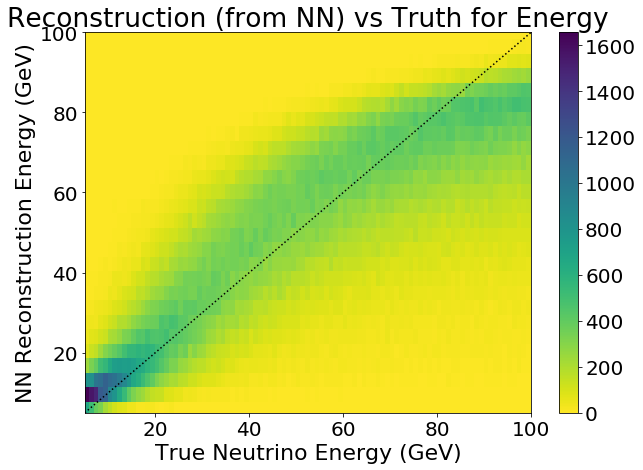

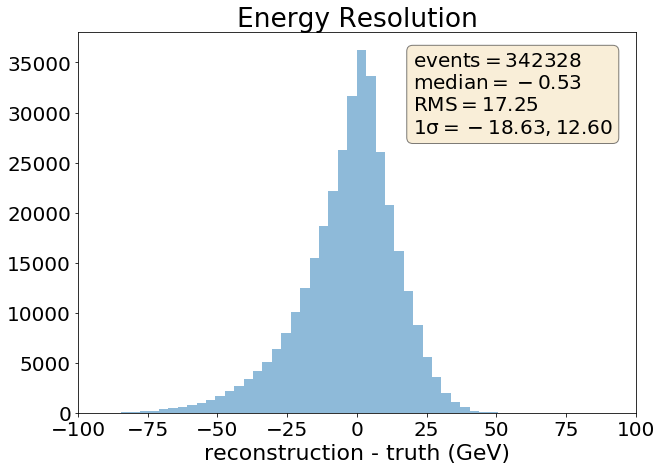

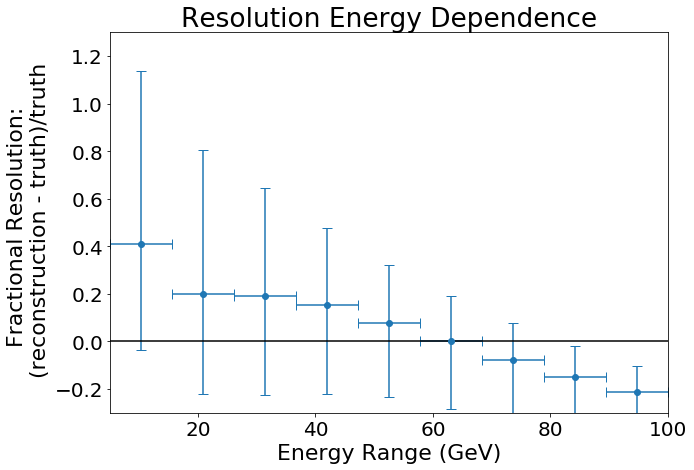

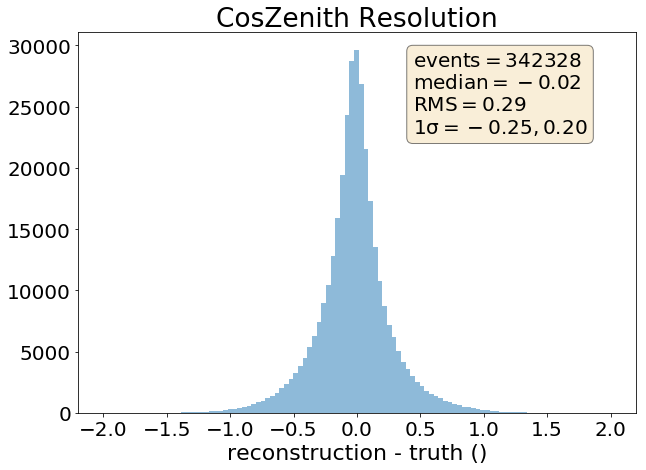

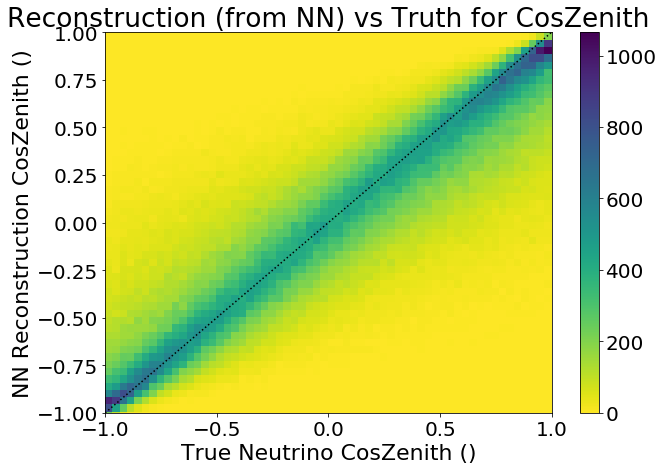

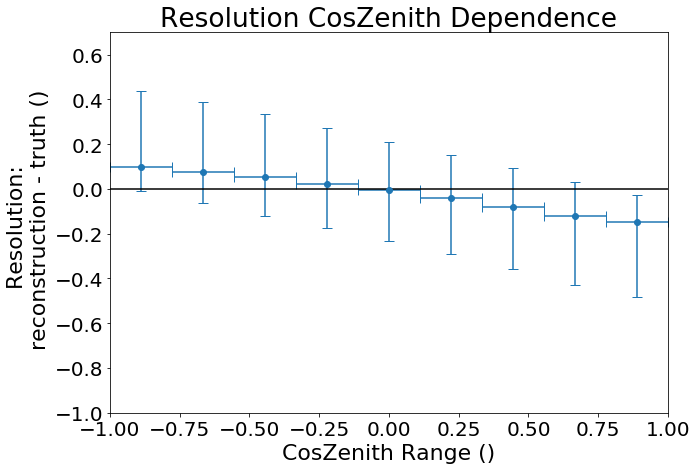

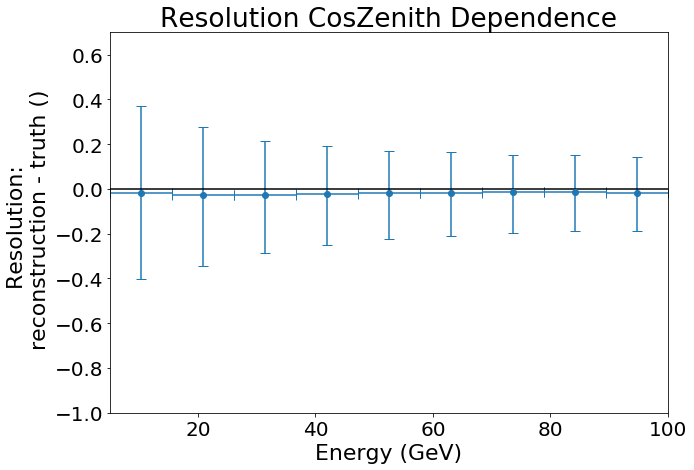

In [14]:
#plot_history(network_history,save,save_folder_name)
Y_test_use = Y_test
save = False
plot_2D_prediction(Y_test_use[:,0]*max_energy, Y_test_predicted[:,0]*max_energy,\
                   save,save_folder_name,bins=int(max_energy-min_energy),\
                   minval=min_energy,maxval=max_energy,\
                   #minval=min(Y_test_predicted[:,0]*max_energy),maxval=max(Y_test_predicted[:,0]*max_energy),\
                   variable="Energy",units='GeV')
plot_single_resolution(Y_test_use[:,0]*max_energy, Y_test_predicted[:,0]*max_energy,\
                       save=save,savefolder=save_folder_name,\
                       variable="Energy",units='GeV')
plot_bin_slices(Y_test_use[:,0]*max_energy, Y_test_predicted[:,0]*max_energy, \
                       use_fraction = True, \
                       bins=10,min_val=5.,max_val=100.,\
                       save=True,savefolder=save_folder_name,\
                       variable="Energy",units="GeV")
if num_labels > 1:
    plot_single_resolution(Y_test_use[:,1], Y_test_predicted[:,1],\
                       save=save,savefolder=save_folder_name,\
                       variable="CosZenith",units='')
    plot_2D_prediction(Y_test_use[:,1], Y_test_predicted[:,1],\
                       save,save_folder_name,\
                       minval=-1.,maxval=1.,
                       #minval=min(Y_test_predicted[:,1]),maxval=max(Y_test_predicted[:,1]),\
                       variable="CosZenith",units='')
    plot_bin_slices(Y_test_use[:,1], Y_test_predicted[:,1], \
                       use_fraction = False, \
                       bins=10,min_val=-1.,max_val=1.,\
                       save=True,savefolder=save_folder_name,\
                       variable="CosZenith",units="")
    plot_bin_slices(Y_test_use[:,1], Y_test_predicted[:,1], \
                       min_energy = 5., max_energy=100., true_energy=Y_test_use[:,0], \
                       use_fraction = False, \
                       bins=10,min_val=-1.,max_val=1.,\
                       save=True,savefolder=save_folder_name,\
                       variable="CosZenith",units="")
    
if num_labels > 2:
    plot_single_resolution(Y_test_use[:,2], Y_test_predicted[:,2],\
                       save=save,savefolder=save_folder_name,\
                       variable="Track",units='m')
    plot_2D_prediction(Y_test_use[:,2], Y_test_predicted[:,2],save,save_folder_name,minval=0,maxval=150,variable="Track",units='m')


In [25]:
def plot_distributions(truth,reco,save=False,savefolder=None,variable="Energy",units="GeV"):
    """
    Plot testing set distribution, with CC and NC distinguished
    Recieves:
        truth_all_labels = array, Y_test truth labels that have ALL values in them (need CC vs NC info)
        truth = array, Y_test truth labels
        reco = array, neural network prediction output
        save = optional, bool to save plot
        savefolder = optional, output folder to save to, if not in current dir
    Returns:
        1D histogram of reco - true with sepearated CC and NC distinction
    """
    print(len(truth),len(reco))
    plt.figure(figsize=(10,7))
    plt.title("%s Distribution"%variable)
    plt.hist(truth, bins=100,color='b',alpha=0.5,label="Truth");
    plt.hist(reco, bins=100,color='g', alpha=0.5, label="Neural Net");
    plt.xlabel("%s (%s)"%(variable,units))
    plt.legend()
    if save:
        plt.savefig("%s%sDistribution.png"%(savefolder,variable))

342328 342328
342328 342328


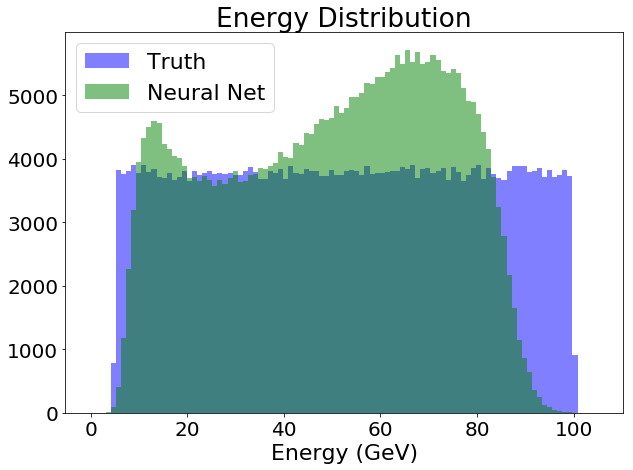

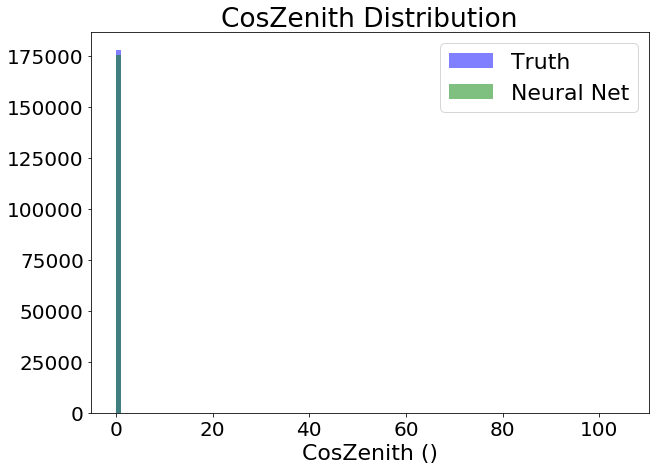

In [26]:
plot_distributions(Y_test_use[:,0]*max_energy, Y_test_predicted[:,0]*max_energy,save,save_folder_name,variable="Energy",units='GeV')
if train_variables > 1:
    plot_distributions(Y_test_use[:,1], Y_test_predicted[:,1],save,save_folder_name,variable="CosZenith",units='')

In [21]:
def plot_history_from_list(loss,val,save=False,savefolder=None,logscale=False,ymin=None,ymax=None,title=None):

    plt.figure(figsize=(10,7))
    plt.plot(loss,label="Training")
    plt.plot(val,label="Validation")

    #Edit Axis
    if logscale:
        plt.yscale('log')
    if ymin and ymax:
        plt.ylim(ymin,ymax)
    elif ymin:
        plt.ylim(ymin,max(max(loss),max(val)))
    elif ymax:
        plt.ylim(min(min(loss),min(val)),ymax)
    
    #Add labels
    if title:
        plt.title(title,fontsize=25)
    else:
        plt.title("Training and Validation Loss after %s Epochs"%len(loss),fontsize=25)
    plt.xlabel('Epochs',fontsize=15)
    plt.ylabel('Loss',fontsize=15)
    plt.legend(fontsize=15)
    
    if save == True:
        plt.savefig("%sloss_vs_epochs.png"%savefolder) 

def plot_history_from_list_split(energy_loss,val_energy_loss,zenith_loss,val_zenith_loss,save=True,savefolder=None,logscale=False,ymin=None,ymax=None,title=None):
    
    plt.figure(figsize=(10,7))
    plt.plot(energy_loss,'b',label="Energy Training")
    plt.plot(val_energy_loss,'c',label="Energy Validation")
    plt.plot(zenith_loss,'r',label="Zenith Training")
    plt.plot(val_zenith_loss,'m',label="Zenith Validation")
    
    #Edit Axis
    if logscale:
        plt.yscale('log')
    if ymin and ymax:
        plt.ylim(ymin,ymax)
    elif ymin:
        plt.ylim(ymin,max(max(loss),max(val)))
    elif ymax:
        plt.ylim(min(min(loss),min(val)),ymax)
    
    #Add labels
    if title:
        plt.title(title,fontsize=25)
    else:
        plt.title("Training and Validation Loss after %s Epochs"%len(loss),fontsize=25)
    plt.xlabel('Epochs',fontsize=15)
    plt.ylabel('Loss',fontsize=15)
    plt.legend(fontsize=15)
    
    if save == True:
        plt.savefig("%sloss_vs_epochs_split.png"%savefolder)

In [43]:
loss = [0.5638999951078618, 0.2239334302986391, 0.19283099259803776, 0.17831793874810273, 0.16933146295170354, 0.1623940180171268, 0.15701697301086504, 0.15175904069072405, 0.1485293520498928, 0.14525219177062468, 0.143026797637058, 0.14061696721136813, 0.13922084267327053, 0.13808920109869366, 0.1359546336845622, 0.1349402300857223, 0.13356690338660182, 0.13329635906354365, 0.13162642174002134, 0.13152821981740725, 0.13094031182784108, 0.12926689196630475, 0.1293103421377404, 0.1285733627405748, 0.12844751202992166, 0.12706007775183095, 0.1274929534685955, 0.1270949258915883, 0.12597768137328932, 0.1255366959911322, 0.1252374675083325, 0.12501614519976817, 0.12405872912757321, 0.12439822209244182, 0.12435718178285252, 0.12360958461380876, 0.12342124097300619, 0.12267334657091009, 0.12307837775705717, 0.12219016584707065, 0.1221145060866197, 0.12247331352731142, 0.12141296436113697, 0.12139676884637733, 0.12083616820901563, 0.12121685678656272, 0.1203979852246249, 0.12055927246278816, 0.12083020453266813, 0.12016058958029342, 0.11986749792894351, 0.11929275963300631, 0.11944469246214576, 0.11897223062079108, 0.11924624522125524, 0.1193746657295588, 0.11855405238334613, 0.11869491323007006, 0.11806207767843921, 0.11838750547033454, 0.1178212810809745, 0.1181448194027188, 0.11824699643142106, 0.11757574292507986, 0.1176088695095417, 0.11708256893992935, 0.11723069140625247, 0.11686804579628911, 0.11721885055449155, 0.11719036693118179, 0.11659451264420748, 0.11640508353711529, 0.11615885877753887, 0.11638572454084159, 0.11564945329298172, 0.11614410708383167, 0.11632392365138963, 0.1156984103696168, 0.11563130562199765, 0.1152476899514935, 0.1150937840757938, 0.11478221347051103, 0.11550504801362754, 0.1154217529873212, 0.11473050427115059, 0.11466010398359529, 0.11469759701219227, 0.11474595719174076, 0.11429667204426827, 0.11474037077880964, 0.11480370693452306, 0.11424703278574988, 0.11396389726147428, 0.11345375379346413, 0.11387615585143376, 0.11342607003951331, 0.11387816977910441, 0.11406401470386696, 0.11349957245695425, 0.11356921858791517, 0.11316319086574932, 0.11331888141492565, 0.11297303198822799, 0.11319221749235142, 0.11348130788365368, 0.11281584686423048, 0.11300189230350934, 0.11251181622213526, 0.11293486133412485, 0.1120793790256926, 0.1126066575789328, 0.11275569432653208, 0.1122723216734285, 0.11204583556251536, 0.11174303001911853, 0.11216458637211742, 0.11165973027744922, 0.1122614345105422, 0.11228974950989071, 0.11163957688843272, 0.11154822432520584, 0.11103302637759702, 0.11146977024289442, 0.11120121633026293, 0.11142351819220121, 0.11199338040009736, 0.11113276943248536, 0.1110711180181008, 0.11089381241321433, 0.11117872452253381, 0.11093390523958062, 0.11106507492654394, 0.11147786068852941, 0.11056505789247685, 0.11062843444662218, 0.11015588289037755, 0.11047463732607224, 0.110280273830119, 0.11055805779870127, 0.1109046842209636]
energy_loss = [0.15550967, 0.037588038, 0.035568137, 0.034639355, 0.033945713, 0.03327894, 0.032966755, 0.032625023, 0.0322728, 0.03226088, 0.032222714, 0.03186591, 0.03165008, 0.031648275, 0.031532273, 0.031265575, 0.031386234, 0.031446733, 0.03118187, 0.031053169, 0.03117458, 0.030990256, 0.030871568, 0.031020671, 0.031003218, 0.030852046, 0.030774754, 0.030767942, 0.030717527, 0.030529108, 0.030689718, 0.030725678, 0.030544037, 0.030486267, 0.03051118, 0.030521581, 0.030305902, 0.030519001, 0.030561931, 0.030357732, 0.030343901, 0.030383606, 0.030305084, 0.030173955, 0.03038362, 0.030393701, 0.03020146, 0.030174686, 0.030171003, 0.030144816, 0.029999666, 0.030219214, 0.030247126, 0.03010139, 0.02998931, 0.030090354, 0.030008905, 0.029896554, 0.0300258, 0.030118976, 0.029999677, 0.029937148, 0.029967625, 0.029886352, 0.029849455, 0.029981095, 0.030034583, 0.029847555, 0.029787917, 0.02986984, 0.029800914, 0.029693434, 0.029927066, 0.02996283, 0.029773384, 0.029693473, 0.029741764, 0.029753594, 0.029670749, 0.029785246, 0.029834652, 0.029716214, 0.029657431, 0.029666867, 0.029662525, 0.029524075, 0.029764755, 0.029761577, 0.029657222, 0.029691195, 0.02965315, 0.02956341, 0.02942251, 0.029621795, 0.029744212, 0.029585026, 0.02952467, 0.029585836, 0.029502572, 0.029405752, 0.029627448, 0.02959573, 0.029502533, 0.029428137, 0.02947501, 0.029440405, 0.02933643, 0.029499734, 0.029578578, 0.029441897, 0.02938074, 0.029420534, 0.029440029, 0.029273937, 0.029457398, 0.0294969, 0.029380139, 0.029315494, 0.029369796, 0.029357472, 0.029196473, 0.029364625, 0.029439462, 0.029300557, 0.029298505, 0.029320626, 0.029277813, 0.029149361, 0.029397367, 0.029456638, 0.029314142, 0.02926144, 0.02933749, 0.029230272, 0.029159846, 0.02927212, 0.029369324, 0.02925237, 0.029204385, 0.029278098]
zenith_loss = [0.40826288, 0.18632348, 0.15726434, 0.1436809, 0.1353834, 0.12911461, 0.124052815, 0.11912437, 0.1162543, 0.11300839, 0.110805124, 0.10874642, 0.10756007, 0.10645682, 0.104434416, 0.10367584, 0.102185026, 0.10185147, 0.10042583, 0.10047168, 0.099778384, 0.09827941, 0.09842643, 0.097561724, 0.09745144, 0.09622283, 0.096716605, 0.0963242, 0.09526584, 0.09499137, 0.09454786, 0.09429675, 0.09350851, 0.093909584, 0.09385347, 0.09310239, 0.09312135, 0.09215571, 0.09253166, 0.091832735, 0.09177018, 0.0920797, 0.09112598, 0.091220856, 0.090459116, 0.090823464, 0.09020548, 0.09037769, 0.09067296, 0.09001863, 0.08986939, 0.08908186, 0.089189686, 0.08886574, 0.08924892, 0.089282274, 0.08854811, 0.088796094, 0.08803863, 0.088267796, 0.08782257, 0.088200666, 0.08827636, 0.08769377, 0.08776977, 0.08710579, 0.08720519, 0.08701516, 0.08742606, 0.08733001, 0.086790845, 0.08670682, 0.08623904, 0.086427584, 0.08588332, 0.08644478, 0.086572744, 0.085946515, 0.08595981, 0.085468285, 0.0852601, 0.08504919, 0.08584607, 0.085759975, 0.08507587, 0.08513062, 0.08493146, 0.08498455, 0.08464664, 0.085048944, 0.08515062, 0.08468747, 0.084551305, 0.08382776, 0.084135115, 0.0838471, 0.084350444, 0.084483504, 0.083988585, 0.08416785, 0.08352567, 0.083717525, 0.08348033, 0.083770126, 0.08399774, 0.08337707, 0.08366991, 0.08302133, 0.08335715, 0.0826491, 0.08321763, 0.083328165, 0.08282708, 0.08276288, 0.082279354, 0.082673885, 0.08228025, 0.08296915, 0.08292618, 0.08229982, 0.082360156, 0.08166964, 0.08203063, 0.08189389, 0.08212457, 0.08266897, 0.08185607, 0.08192282, 0.08149198, 0.08171702, 0.08162981, 0.08179736, 0.082149215, 0.08133359, 0.08146776, 0.08087539, 0.08111539, 0.08102661, 0.08134692, 0.081617005]
val_loss = [0.394022817072, 0.573355834896, 0.250535101387, 0.228237041945, 0.233041720022, 0.247482862849, 0.151887489232, 0.152687380063, 0.190007121193, 0.207976313826, 0.161015151467, 0.226186754887, 0.289305672327, 0.133072072175, 0.210011766468, 0.143608885297, 0.182214033821, 0.164273559331, 0.154381006992, 0.339779197202, 0.248383012771, 0.127894555715, 0.129773491128, 0.140571468295, 0.210105873732, 0.142254334373, 0.12772407969, 0.176625721526, 0.19905991375, 0.200084088553, 0.127621968444, 0.132488157884, 0.153470396469, 0.122736966303, 0.131031131465, 0.169515412473, 0.128074867064, 0.117216309743, 0.188398196719, 0.138289330989, 0.15674331288, 0.168093228985, 0.343597103952, 0.144657619732, 0.119342761664, 0.133307886822, 0.158677554659, 0.219265044858, 0.121408505262, 0.116091851549, 0.11703690687, 0.120524416426, 0.149856689332, 0.118199916274, 0.161296591539, 0.146916129106, 0.124428334351, 0.127492061259, 0.158533703127, 0.131427133765, 0.21825614932, 0.142256931701, 0.118666523368, 0.165502889985, 0.136004000557, 0.120213584607, 0.112217760043, 0.141374603849, 0.118238516617, 0.175675325272, 0.129140498792, 0.118393313852, 0.115885860156, 0.113745267031, 0.131933056648, 0.154631275642, 0.122732612727, 0.128352834146, 0.115539795819, 0.10983907473, 0.11109437114, 0.131788325542, 0.1170774916, 0.113352908733, 0.132185875365, 0.112582477489, 0.127420854052, 0.135296090329, 0.123481410244, 0.130575774666, 0.132585826084, 0.135616242912, 0.113452993252, 0.122115692074, 0.115205643437, 0.113597899602, 0.150643600432, 0.138697112971, 0.148586288891, 0.136189970679, 0.116151088268, 0.112081134482, 0.119023801092, 0.125231547828, 0.126967870403, 0.124733341263, 0.117867576252, 0.132714470727, 0.132237718251, 0.116900582158, 0.190628802653, 0.110554488097, 0.120119609195, 0.124267466409, 0.106809807461, 0.113784762551, 0.114008703089, 0.139564014417, 0.120376021375, 0.114262362795, 0.118270922935, 0.112380055454, 0.144797024767, 0.122139844046, 0.129144456244, 0.110558108886, 0.114949967681, 0.115811549424, 0.142504110647, 0.113877401439, 0.112862766196, 0.120207531305, 0.165889982365, 0.12573349922, 0.120982592423, 0.109405072289, 0.120607218346, 0.153879591373, 0.109135548652, 0.116331835364]
val_energy_loss = [0.0775719955564, 0.0593158043921, 0.0465048626065, 0.0628187432885, 0.0413427315652, 0.0377364903688, 0.0352823026478, 0.0348116159439, 0.0600509867072, 0.0370377153158, 0.0408153794706, 0.0877494812012, 0.0365088619292, 0.031599689275, 0.0495697408915, 0.0343536734581, 0.0365188382566, 0.0321844927967, 0.031935788691, 0.0499625578523, 0.0528747923672, 0.0321327857673, 0.0322325155139, 0.0345133244991, 0.102750509977, 0.0346213467419, 0.036926984787, 0.0609267577529, 0.0484205447137, 0.0566472224891, 0.0304790660739, 0.0338081754744, 0.0326008461416, 0.0306869056076, 0.0380394160748, 0.0327578857541, 0.0345912463963, 0.0299802850932, 0.0624068379402, 0.0362360104918, 0.0389572419226, 0.0440796203911, 0.0749352946877, 0.0422819927335, 0.0297917630523, 0.0413207635283, 0.0406340807676, 0.0383983701468, 0.0303600449115, 0.030128179118, 0.0329958684742, 0.0307873357087, 0.0460160113871, 0.0321281589568, 0.0324660949409, 0.0446351505816, 0.0354426056147, 0.0336453020573, 0.0510150268674, 0.0375271216035, 0.0364569909871, 0.0474719442427, 0.0298326872289, 0.0433725714684, 0.0485762283206, 0.0296570509672, 0.0288932397962, 0.0428793691099, 0.0319277867675, 0.0544824041426, 0.0366701595485, 0.0378783009946, 0.0303648952395, 0.0298844985664, 0.0353197529912, 0.0585823729634, 0.0370423197746, 0.0334083475173, 0.0291820783168, 0.0286782179028, 0.0289947707206, 0.0320187434554, 0.0298707298934, 0.0295429453254, 0.0311469566077, 0.0291054584086, 0.0395205505192, 0.0416622012854, 0.030048949644, 0.0381202101707, 0.0361802577972, 0.0432674735785, 0.0295066833496, 0.0355735532939, 0.0304613169283, 0.0313080698252, 0.0516285337508, 0.0317232310772, 0.0449534840882, 0.0545871593058, 0.034324105829, 0.0303748976439, 0.033246640116, 0.0365763753653, 0.0328441224992, 0.035665884614, 0.0364547967911, 0.0404234193265, 0.0416997410357, 0.0291034728289, 0.0330190062523, 0.02905536443, 0.0312474407256, 0.039144679904, 0.0284027867019, 0.029917165637, 0.0330932214856, 0.0529744401574, 0.0311031397432, 0.0327763147652, 0.0394699536264, 0.031456977129, 0.0352955944836, 0.0342988520861, 0.0370184443891, 0.0289616864175, 0.0334815755486, 0.0377130322158, 0.0544466748834, 0.0337300077081, 0.0315233618021, 0.029530832544, 0.0315783843398, 0.0406441949308, 0.031077362597, 0.0288178343326, 0.0313184298575, 0.0469093173742, 0.0302567780018, 0.03014289774, ]
val_zenith_loss = [0.316430836916, 0.514036953449, 0.204032227397, 0.165422201157, 0.191696166992, 0.209748089314, 0.116612009704, 0.117879398167, 0.129962176085, 0.170938447118, 0.12020304054, 0.138427242637, 0.252778351307, 0.10147818923, 0.160441815853, 0.109250001609, 0.145700469613, 0.132101535797, 0.122440561652, 0.289800554514, 0.195505276322, 0.0957618057728, 0.0975393503904, 0.106063455343, 0.107360117137, 0.107627414167, 0.0907909572124, 0.115702651441, 0.150646179914, 0.143438339233, 0.0971457585692, 0.0986868143082, 0.120859593153, 0.0920443460345, 0.0929920598865, 0.13674557209, 0.0934845209122, 0.0872400924563, 0.12599158287, 0.102048307657, 0.117784507573, 0.124009788036, 0.268672645092, 0.102375894785, 0.0895549729466, 0.0919854566455, 0.118030257523, 0.180852621794, 0.0910465195775, 0.0859640911222, 0.0840432345867, 0.0897377431393, 0.103849686682, 0.0860685929656, 0.128827437758, 0.102281995118, 0.0889874175191, 0.0938480421901, 0.107515193522, 0.0939011573792, 0.181794852018, 0.0947755873203, 0.0888345018029, 0.122133642435, 0.0874286666512, 0.090555883944, 0.0833254605532, 0.098494105041, 0.0863076001406, 0.121190838516, 0.0924712195992, 0.0805192291737, 0.0855230465531, 0.0838647335768, 0.0966108888388, 0.0960490852594, 0.0856944397092, 0.0949526131153, 0.0863588824868, 0.0811661705375, 0.0820997208357, 0.099762186408, 0.0872043520212, 0.0838102772832, 0.101032055914, 0.083475753665, 0.0879005938768, 0.0936380624771, 0.0934232994914, 0.092447668314, 0.096409201622, 0.0923470705748, 0.0839487537742, 0.0865423157811, 0.0847510322928, 0.0822817459702, 0.0990079641342, 0.106972083449, 0.103636652231, 0.0816063806415, 0.0818281248212, 0.0817087739706, 0.0857662111521, 0.0886528864503, 0.0941220670938, 0.089069083333, 0.0814144536853, 0.0922924503684, 0.0905432552099, 0.0877931043506, 0.157614216208, 0.0814997553825, 0.088879160583, 0.0851240754128, 0.0784079059958, 0.0838715583086, 0.0809079259634, 0.0865878611803, 0.0892720520496, 0.0814873203635, 0.0788025483489, 0.0809253454208, 0.10949857533, 0.0878368839622, 0.0921229720116, 0.0815981850028, 0.0814665406942, 0.0781021863222, 0.0880583226681, 0.0801501199603, 0.0813334062696, 0.0906741097569, 0.1343113482, 0.085088737309, 0.0899101346731, 0.0805906802416, 0.0892946720123, 0.106975831091, 0.0788729190826, 0.0861921831965, ]

In [44]:
loss = loss + [0.10991829392893103, 0.11017622807060687, 0.10980781718468646, 0.1102257953427338, 0.10944640406289152, 0.11020226664924969, 0.1103650317832762, 0.10972683219771887, 0.10962380198807738, 0.1092282798760557, 0.10949566513008778, 0.10931205108409343, 0.10982436650358733, 0.10984844686503388, 0.10921370255078497, 0.10913355107968363, 0.1089000931222987, 0.10946971010804823, 0.10881310725899108, 0.10932522480990196, 0.10953113573563283, 0.1088439852782717, 0.108916149915214, 0.10834853946935791, 0.10896559641355305, 0.1086332226940246, 0.10929904286297998, 0.1089212283464707, 0.10841479531258857, 0.10817803078455539, 0.10804837135463866, 0.10837045170222367, 0.10825180127714655, 0.10849728999425007, 0.10847512311209906, 0.10795520223717617, 0.10796817343848708, 0.1079291186767512, 0.10795573705049244, 0.10759288962548966, 0.10806378055053008, 0.10854836108394794, 0.10762614416922539, 0.1076798833079034, 0.1073643726990586, 0.10750004853112478, 0.10730273484478828, 0.10788024465513872, 0.10795079024775939, 0.10728362598221035, 0.10733369583665148, 0.10674998484034075, 0.10729071245383238, 0.10695347178527552, 0.10753407259797051, 0.10768764367798221, 0.10668775160100495, 0.10703836090339164, 0.10686864341039061, 0.10721398673778451, 0.10642119348313243, 0.10688629158015057, 0.10735676838509609, 0.10644077722309822, 0.10657183781059351, 0.10632569075641009, 0.10691504878479992, 0.10621829062474789, 0.10660122590368842, 0.10680027815309273 ]
energy_loss = energy_loss + [0.029138973, 0.029081358, 0.029296922, 0.029310776, 0.029242357, 0.02917456, 0.02918312, 0.029172672, 0.029029772, 0.02920605, 0.029252272, 0.02916364, 0.029168999, 0.029155595, 0.029127637, 0.029056627, 0.02920234, 0.029289512, 0.02910375, 0.029037697, 0.029110642, 0.029126149, 0.028956888, 0.029145438, 0.029218549, 0.029133018, 0.029102467, 0.029133653, 0.02899453, 0.02896206, 0.029136086, 0.029177785, 0.029041683, 0.02899293, 0.029057145, 0.028998215, 0.028935153, 0.029135926, 0.029129399, 0.029026987, 0.028968386, 0.02905134, 0.028967079, 0.02887976, 0.02907758, 0.029124146, 0.02901462, 0.028981164, 0.028968856, 0.028935766, 0.028869124, 0.02904879, 0.02907842, 0.028921178, 0.028943744, 0.02898672, 0.02890321, 0.028861715, 0.028997684, 0.029074242, 0.028948637, 0.028874433, 0.02897862, 0.028924357, 0.028807448, 0.028993323, 0.029055335, 0.028936187, 0.02888634, 0.028879171]
zenith_loss = zenith_loss + [0.080789186, 0.081082374, 0.080523714, 0.0809128, 0.080202416, 0.08102792, 0.08118782, 0.08054758, 0.08060123, 0.08002806, 0.08024807, 0.08014849, 0.08065907, 0.0806936, 0.080087796, 0.08007207, 0.07970134, 0.08018929, 0.07971244, 0.08028202, 0.08041049, 0.079731494, 0.07996243, 0.07919696, 0.079744905, 0.07949863, 0.08021285, 0.07979045, 0.079412706, 0.07920249, 0.078920804, 0.07918835, 0.07920819, 0.079502515, 0.07941368, 0.07895945, 0.079031914, 0.07878297, 0.07882694, 0.078561604, 0.079103835, 0.07949359, 0.07866591, 0.07881098, 0.078279786, 0.07838536, 0.07829409, 0.07890411, 0.07899027, 0.07836102, 0.078463495, 0.077703506, 0.078211956, 0.07803517, 0.07858998, 0.07870036, 0.07777488, 0.07817831, 0.07788679, 0.07815569, 0.07748163, 0.07801273, 0.07837176, 0.077517726, 0.0777627, 0.07733289, 0.077861995, 0.07729061, 0.0777098, 0.07793483]
val_loss = val_loss + [0.141041573864, 0.106204366043, 0.129304644519, 0.11279274756, 0.113638713852, 0.131642428264, 0.150804674667, 0.114048917035, 0.117638524639, 0.108708437444, 0.161494200033, 0.124672583914, 0.16404557663, 0.106979214303, 0.111194762935, 0.116429949059, 0.116666371859, 0.12006722354, 0.107142147563, 0.125568532622, 0.108623125923, 0.108739283938, 0.14402418011, 0.109624515914, 0.137716910469, 0.12300079407, 0.111884810854, 0.107742063022, 0.10806494702, 0.1341643604, 0.116198132388, 0.120131259054, 0.118553284553, 0.123811286898, 0.114579847015, 0.119070598362, 0.110218468106, 0.106277802185, 0.126297671618, 0.106699870973, 0.107474640752, 0.121637861397, 0.112373810399, 0.10909041906, 0.10746504487, 0.112737053313, 0.140975886198, 0.141314039117, 0.128497127285, 0.114965444389, 0.105298184654, 0.10640360242, 0.106606740364, 0.156642075803, 0.112980025217, 0.111781594565, 0.118674670343, 0.127448699936, 0.123843126995, 0.122309698971, 0.135920303516, 0.135456622896, 0.130257609121, 0.120112814918, 0.12403980122, 0.123634161972, 0.109042447888, 0.115540045008, 0.143987012654, 0.108756286112]
val_energy_loss = val_energy_loss + [0.050470802933, 0.0290748011321, 0.0305640175939, 0.0351977944374, 0.0346945375204, 0.0317458622158, 0.038238696754, 0.0314339771867, 0.0359351374209, 0.028605369851, 0.0315122157335, 0.0329869203269, 0.0432911626995, 0.0290328487754, 0.0309980083257, 0.0376694537699, 0.0319585055113, 0.0344555675983, 0.0296017341316, 0.0404364801943, 0.0287220478058, 0.0301562324166, 0.050127916038, 0.0285475328565, 0.0418572463095, 0.0425641536713, 0.0307184644043, 0.0283198859543, 0.0306278821081, 0.0460299104452, 0.0342551283538, 0.0312695875764, 0.0334042459726, 0.0318680219352, 0.0310960784554, 0.038249656558, 0.0324535407126, 0.0286438018084, 0.0405994281173, 0.0285669285804, 0.0289953332394, 0.0359781496227, 0.0299219191074, 0.0285216756165, 0.0303792431951, 0.0303864199668, 0.0535961911082, 0.0483165942132, 0.0489188618958, 0.0330305248499, 0.0284034367651, 0.0285720359534, 0.0290869828314, 0.0342359021306, 0.0320095941424, 0.0347361080348, 0.0341264605522, 0.0376222617924, 0.0311523675919, 0.0386647731066, 0.0334633737803, 0.0305991861969, 0.0373284108937, 0.0383871048689, 0.038463357836, 0.0381085984409, 0.0303225181997, 0.0296203680336, 0.0475682653487, 0.0290893986821 ]
val_zenith_loss = val_zenith_loss + [0.0905662253499, 0.0771290510893, 0.0987328067422, 0.0775972008705, 0.0789380446076, 0.0998969003558, 0.112570129335, 0.0826216191053, 0.0817032530904, 0.0801083669066, 0.129981890321, 0.0916740298271, 0.12074995786, 0.0779497921467, 0.0802035853267, 0.0787634775043, 0.0847107842565, 0.0856143087149, 0.0775328278542, 0.0851218774915, 0.0798995643854, 0.07858402282, 0.093898139894, 0.081080250442, 0.09586147964, 0.0804301947355, 0.0811609774828, 0.0794218853116, 0.0774372965097, 0.0881385952234, 0.081949904561, 0.0888647958636, 0.0851471424103, 0.0919379368424, 0.0834871083498, 0.0808272212744, 0.0777679085732, 0.0776365697384, 0.085697427392, 0.0781268775463, 0.0784753039479, 0.0856613516808, 0.0824556350708, 0.0805719196796, 0.0770882740617, 0.0823527574539, 0.0873786360025, 0.0929834321141, 0.0795871540904, 0.0819352343678, 0.0768972858787, 0.0778296366334, 0.0775202289224, 0.122393108904, 0.0809638425708, 0.0770436525345, 0.0845472738147, 0.0898233950138, 0.0926927030087, 0.0836504027247, 0.102462083101, 0.104854740202, 0.0929405167699, 0.0817229002714, 0.0855797380209, 0.0855218842626, 0.0787225663662, 0.0859119743109, 0.0964067578316, 0.0796663910151]

In [45]:
loss = loss +[0.10604844205820375, 0.10615023900453746, 0.10592440661287794, 0.10637667059872646, 0.1059037862001131, 0.10634355221662373, 0.10680105793564064, 0.10571456305714654, 0.10606557243368776, 0.10572027775538745, 0.1061024710043733, 0.10543114920451788, 0.10598636815359594, 0.1059682045389664, 0.10506381233994345, 0.10555224946015906, 0.10539303027399641, 0.10589981078475222, 0.10548791019071833, 0.10574563676161916, 0.10598248762675908, 0.10512837821060067, 0.10524156737838264, 0.10486324070225875, 0.10542726972208995, 0.10490688361186716, 0.10547106969619396, 0.10570956789041569, 0.10481975211698856, 0.10508417304225802, 0.10473163828812036, 0.10519654493282696, 0.104883092548184, 0.10510043414118798, 0.10560018023940361, 0.10464037771018507, 0.1048372966384789, 0.10447617142907063, 0.10524329407299271, 0.10436481012216503, 0.1050111152282647, 0.10532790020742226, 0.1043697653402513, 0.10441108785893503, 0.10417755855351868, 0.10469010169944228, 0.10408965019125817, 0.10465636101467539, 0.10482039667969671, 0.10392290511833033, 0.10430034703779673, 0.10441264556740955, 0.10417129507032426, 0.10367214428182842, 0.10438527111911612, 0.1045634430732536, 0.10358224232597449, 0.1038988171258273, 0.10342100774040902, 0.10395020100856053, 0.10367231214816776, 0.10406641716832556, 0.10431808218914472, 0.10341362921425466, 0.10366471210313126, 0.10331920760870793, 0.10387073015755266, 0.10311343412522746, 0.10380121715233277, 0.10395622000675946]
energy_loss = energy_loss + [0.028860489, 0.028786233, 0.029017545, 0.029008383, 0.028878722, 0.028800044, 0.028905733, 0.028772347, 0.028792359, 0.028953979, 0.029038416, 0.02889608, 0.02881922, 0.0288547, 0.028795825, 0.028786575, 0.0289159, 0.029057996, 0.02891217, 0.028872207, 0.02890585, 0.028813029, 0.028761858, 0.028922778, 0.02898371, 0.028809594, 0.028829636, 0.028792886, 0.028789664, 0.028725538, 0.02891108, 0.02896159, 0.028832508, 0.028776119, 0.028896878, 0.028775293, 0.028753154, 0.02887002, 0.029039776, 0.028805206, 0.028806834, 0.028877743, 0.028720712, 0.028690513, 0.028880127, 0.028924232, 0.028734373, 0.028743856, 0.028826145, 0.028754253, 0.028668873, 0.028954552, 0.028933411, 0.028780516, 0.028730024, 0.028826239, 0.028725898, 0.028656982, 0.028851392, 0.0288696, 0.028758243, 0.028711613, 0.028804928, 0.028696753, 0.028606847, 0.028818963, 0.028926505, 0.02871601, 0.028703768, 0.028774709 ]
zenith_loss = zenith_loss + [0.07718736, 0.07737587, 0.076898806, 0.077386625, 0.07702389, 0.077540234, 0.07788773, 0.07693325, 0.07726603, 0.07676233, 0.07706498, 0.07652603, 0.07717823, 0.07711456, 0.076267675, 0.07675802, 0.076486446, 0.076843835, 0.07656764, 0.07687811, 0.07706781, 0.07629898, 0.07648505, 0.075941704, 0.076447524, 0.07611369, 0.07664596, 0.0769177, 0.07602062, 0.0763666, 0.07581934, 0.07623472, 0.07604469, 0.07631681, 0.07670304, 0.075861484, 0.07607643, 0.07561021, 0.07621001, 0.07555452, 0.076206066, 0.07645896, 0.07564273, 0.07572758, 0.07529407, 0.07576647, 0.075357705, 0.075909756, 0.07599068, 0.075164415, 0.07563512, 0.075459614, 0.07524201, 0.07488904, 0.07564814, 0.0757461, 0.07486298, 0.07523516, 0.074563704, 0.07507911, 0.07491298, 0.075348526, 0.07550793, 0.07471755, 0.07505912, 0.07450402, 0.07494397, 0.07439362, 0.075100176, 0.07517817 ]
val_loss = val_loss + [0.116733393821, 0.117075118861, 0.116767385931, 0.105974953654, 0.151012438971, 0.122544623059, 0.106488214201, 0.119767261094, 0.154722510488, 0.114060466562, 0.122413527028, 0.275778889183, 0.113773817909, 0.136453367079, 0.189367961514, 0.126330423801, 0.118149376312, 0.108991813588, 0.347273937312, 0.111970725895, 0.116950291261, 0.106171067697, 0.108466982868, 0.142930671721, 0.125481691601, 0.117138310594, 0.10764038352, 0.108169829849, 0.128082950318, 0.105274504366, 0.117218363354, 0.118137000693, 0.117641536629, 0.107892769137, 0.106762049375, 0.111061031497, 0.115845156942, 0.108604341476, 0.120635855497, 0.114466505384, 0.11267049354, 0.104424534811, 0.115352634574, 0.104796988676, 0.11119850986, 0.120525447782, 0.119416764125, 0.14288181263, 0.201209150507, 0.114795627575, 0.110547138144, 0.157589536731, 0.108819582752, 0.10509448833, 0.105391432406, 0.108673361473, 0.112675472393, 0.107711639196, 0.111637067765, 0.111023223053, 0.11501985623, 0.15172237662, 0.108490655754, 0.113138144789, 0.107240836079, 0.10413434663, 0.122934792794, 0.10777961635, 0.109669446843, 0.112629720796]
val_energy_loss = val_energy_loss + [0.0292987078428, 0.0352399274707, 0.0384552851319, 0.0285490565002, 0.0346422158182, 0.0391571298242, 0.0284351278096, 0.0350254960358, 0.075665473938, 0.0363145694137, 0.0412735491991, 0.0374571271241, 0.0296690762043, 0.0365035422146, 0.0390665866435, 0.0302823800594, 0.0411271303892, 0.0290658753365, 0.0453197807074, 0.029566930607, 0.0352625511587, 0.0288329962641, 0.0309037361294, 0.0519642010331, 0.037057697773, 0.035287283361, 0.0289994180202, 0.0284167136997, 0.0311011523008, 0.0283081978559, 0.033418122679, 0.0335407406092, 0.0389951653779, 0.029874522239, 0.0294574946165, 0.0300444308668, 0.0359001755714, 0.0285647530109, 0.0303811617196, 0.0353480316699, 0.0303490832448, 0.0281079094857, 0.0314798206091, 0.0286654252559, 0.0319641046226, 0.0364661850035, 0.0320638455451, 0.0595065876842, 0.0324632525444, 0.030748333782, 0.0290469899774, 0.0305386371911, 0.029879393056, 0.0282058957964, 0.0287150423974, 0.0306126326323, 0.0302852205932, 0.0305168759078, 0.0364210791886, 0.0295060928911, 0.0307343862951, 0.0616021938622, 0.0313949547708, 0.0350256450474, 0.0293616410345, 0.0282076485455, 0.0318023152649, 0.0292276162654, 0.0309183262289, 0.0305748339742]
val_zenith_loss = val_zenith_loss + [0.0874307975173, 0.0818377956748, 0.0783144980669, 0.0774273723364, 0.116374827921, 0.0833846852183, 0.0780548974872, 0.0847462043166, 0.0790599137545, 0.0777491107583, 0.0811403766274, 0.23833937943, 0.0840959176421, 0.0999511778355, 0.150310561061, 0.0960537791252, 0.0770227611065, 0.0799250379205, 0.301982372999, 0.0823972225189, 0.0816895887256, 0.077339373529, 0.0775654092431, 0.0909618958831, 0.0884334519506, 0.0818415209651, 0.0786340534687, 0.0797549411654, 0.0969790667295, 0.0769667252898, 0.0838002040982, 0.0845950245857, 0.07863907516, 0.0780126899481, 0.0773047730327, 0.081019885838, 0.0799518302083, 0.0800438374281, 0.0902523547411, 0.0791125968099, 0.0823145657778, 0.0763176456094, 0.0838720947504, 0.0761352479458, 0.0792381241918, 0.0840624049306, 0.0873538702726, 0.0833727121353, 0.16876269877, 0.0840502455831, 0.0815013349056, 0.127055004239, 0.0789411216974, 0.0768811032176, 0.0766700878739, 0.0780663117766, 0.0823946148157, 0.0771970227361, 0.0752180889249, 0.0815184488893, 0.0842828303576, 0.0901179984212, 0.077094823122, 0.0781165584922, 0.0778798907995, 0.0759268328547, 0.091128513217, 0.0785432979465, 0.0787451267242, 0.0820553079247]

In [46]:
loss = loss + [0.10331063552029583, 0.10334061066287266, 0.10305204203516238, 0.10331220978228692, 0.1031485729220319, 0.10349125633019572, 0.10383478056422529, 0.10282892605869479, 0.10337202193114048, 0.10280968854295867, 0.10330786209012542, 0.10285300581904518, 0.10321557036981319, 0.10347010785274448, 0.1026148865300692, 0.1029060244745774, 0.10255601454518654, 0.10289974067186396, 0.10266007785917593, 0.10292865968647334, 0.1030726058458043, 0.10235329374569074, 0.1026180516906851, 0.10249069337105374, 0.10263787074257844, 0.10223837438865427, 0.10292047351369193, 0.10303496341933169, 0.10219709246076343, 0.10233049975227833, 0.10198099797184995, 0.10239755760049607, 0.10191116092909284, 0.10277383158317879, 0.10287299946774106, 0.10198019568890287, 0.10219992032115521, 0.10196107501167083, 0.1023160234414285, 0.10166149551550244, 0.1024490572706654, 0.1025038624885482, 0.1018769216455408, 0.10165087403192724, 0.10163408616934834, 0.10199889172942399, 0.10190125700805208, 0.10228380436216143, 0.1022380891937846, 0.10138935404158163, 0.10150910084262432, 0.10147226016616469, 0.101998471106882, 0.10135345080213941, 0.10173262347050452, 0.10210707019575609, 0.10135880835039296, 0.1012770805476666, 0.101313107811776, 0.10144919724831744, 0.10112962368838077, 0.1015583829079886, 0.10173443043442432, 0.10119969634692545, 0.10101491418301638, 0.10101141076658308, 0.10141716861227573, 0.10091224764323393, 0.1013589774792327, 0.10142916875023551, ]
energy_loss = energy_loss + [0.028734745, 0.02860919, 0.028844738, 0.028877547, 0.02870662, 0.028667545, 0.028762113, 0.028636314, 0.028616725, 0.028777005, 0.028847253, 0.02873332, 0.028697416, 0.028760996, 0.028665615, 0.028653376, 0.028786104, 0.028877921, 0.02870606, 0.028645959, 0.02872044, 0.028643232, 0.028580183, 0.028816598, 0.028843043, 0.028665163, 0.028646192, 0.028752811, 0.028617835, 0.02859529, 0.028793942, 0.028846359, 0.028660137, 0.02861828, 0.028696964, 0.028599314, 0.028553197, 0.028757317, 0.028783895, 0.028632753, 0.02867249, 0.028694486, 0.028621672, 0.028572299, 0.02874002, 0.028775102, 0.02867363, 0.028675836, 0.028696707, 0.028639985, 0.028516723, 0.028758237, 0.028799107, 0.02858931, 0.028637359, 0.02867005, 0.028647387, 0.028558828, 0.02870621, 0.028786607, 0.028579563, 0.028565712, 0.028682662, 0.028642694, 0.028545108, 0.028722586, 0.02880231, 0.028660776, 0.028548606, 0.02867899, ]
zenith_loss = zenith_loss + [0.074575335, 0.07472336, 0.07420333, 0.07443494, 0.07444575, 0.07482243, 0.075074024, 0.07419242, 0.07475472, 0.07403146, 0.07445297, 0.074130006, 0.07451296, 0.07472311, 0.073943056, 0.07426366, 0.07376954, 0.074017555, 0.07396543, 0.07427939, 0.07436529, 0.073704794, 0.07403958, 0.073673844, 0.07379641, 0.07357813, 0.07428181, 0.07428566, 0.073579125, 0.07373827, 0.07317538, 0.073548846, 0.07325296, 0.07415763, 0.0741761, 0.073391266, 0.07364107, 0.073214196, 0.07352674, 0.07303104, 0.07378187, 0.073809005, 0.07326119, 0.073081635, 0.072904825, 0.07323342, 0.073228925, 0.073623635, 0.073537365, 0.07274967, 0.073012665, 0.07270325, 0.07320871, 0.07276597, 0.07308898, 0.07343388, 0.07271571, 0.07271665, 0.0726071, 0.07265206, 0.07255473, 0.07300398, 0.07305298, 0.0725576, 0.07246872, 0.07228878, 0.07263011, 0.07226014, 0.07280828, 0.07275089, ]
val_loss = val_loss + [0.121436676374, 0.125826193513, 0.109324398631, 0.343888549991, 0.115878998579, 0.115207857019, 0.112235459723, 0.134351960814, 0.106191090775, 0.111824975238, 0.110685869478, 0.114575078031, 0.10736136487, 0.111309238056, 0.107810980812, 0.129195844407, 0.12058670087, 0.116663867026, 0.106386067809, 0.114452998553, 0.109010624588, 0.144566170931, 0.129779175093, 0.113316315993, 0.13372206909, 0.106239895946, 0.110911070982, 0.137270856341, 0.113414985521, 0.103607863208, 0.108651929298, 0.120251198623, 0.109712000082, 0.113758608114, 0.117626444922, 0.116288370279, 0.105796014389, 0.115633580724, 0.229205109468, 0.114357622341, 0.114898994786, 0.1100390107, 0.106034519548, 0.108463755609, 0.127680204918, 0.10787459133, 0.114605491765, 0.11273532657, 0.126805053102, 0.114086761905, 0.114059544818, 0.106274360383, 0.123277698867, 0.10416371756, 0.105447052234, 0.109112664172, 0.115169520207, 0.124004758544, 0.127551958572, 0.113004097625, 0.108338327637, 0.107610509212, 0.116137831087, 0.109638037646, 0.116319963939, 0.113632508815, 0.132495065324, 0.118092789854, 0.122773770036, 0.108040307905, ]
val_energy_loss = val_energy_loss + [0.0290743689984, 0.0449549108744, 0.0290911123157, 0.0372500680387, 0.0358747057617, 0.03452109918, 0.0346398837864, 0.0437970981002, 0.0303659792989, 0.034468088299, 0.0298269800842, 0.0355617515743, 0.0294802431017, 0.0316066741943, 0.0289139002562, 0.0341171137989, 0.0300595238805, 0.0335847996175, 0.0297391600907, 0.0297036096454, 0.0305914655328, 0.0429772771895, 0.0296982023865, 0.0288782473654, 0.0507554411888, 0.0284849759191, 0.031662825495, 0.0496050417423, 0.0299367979169, 0.0286949537694, 0.029721044004, 0.0390219762921, 0.0303517300636, 0.0342059545219, 0.0342195816338, 0.0349786654115, 0.0283454079181, 0.0344301089644, 0.0424724370241, 0.035236209631, 0.0318165309727, 0.0298633929342, 0.0281836874783, 0.0315677635372, 0.0478598475456, 0.0298084877431, 0.0336376056075, 0.032122425735, 0.045704010874, 0.0336542055011, 0.0325389504433, 0.0284994784743, 0.0400149337947, 0.0279809366912, 0.0281942076981, 0.0312370974571, 0.0315380245447, 0.0372894182801, 0.0399746075273, 0.0290080010891, 0.0287326052785, 0.030821653083, 0.0317497514188, 0.0320572145283, 0.0315371118486, 0.0299506857991, 0.0461164563894, 0.031094301492, 0.0342485718429, 0.0294995289296, ]
val_zenith_loss =  val_zenith_loss + [0.0923616439104, 0.0808718726039, 0.0802399367094, 0.306635886431, 0.0800032913685, 0.080683067441, 0.0775958001614, 0.0905564501882, 0.0758261978626, 0.0773576870561, 0.0808570086956, 0.0790045186877, 0.077876880765, 0.0797011330724, 0.0789002850652, 0.0950850769877, 0.0905241146684, 0.083077698946, 0.0766400918365, 0.0847436338663, 0.0784227773547, 0.101590663195, 0.100083984435, 0.084444001317, 0.0829667523503, 0.0777455791831, 0.079243555665, 0.0876726061106, 0.0834810435772, 0.0749159827828, 0.0789317190647, 0.0812274590135, 0.0793509557843, 0.0795474126935, 0.0834089070559, 0.0813090354204, 0.0774530693889, 0.081206150353, 0.186739698052, 0.0791176557541, 0.0830756425858, 0.0801763981581, 0.0778534710407, 0.0768944323063, 0.0798223093152, 0.0780672729015, 0.0809583291411, 0.0806073695421, 0.0811079069972, 0.0804313197732, 0.0815269649029, 0.0777763202786, 0.0832620561123, 0.0761767700315, 0.0772469639778, 0.0778798833489, 0.083631798625, 0.0867160111666, 0.0875778719783, 0.0839967131615, 0.0795975252986, 0.076784349978, 0.0843901336193, 0.0775821134448, 0.08478538692, 0.0836841985583, 0.0863764435053, 0.0869956985116, 0.0885209068656, 0.0785425528884, ]

In [47]:
loss = loss +[0.1009849609347831, 0.10093431706180077, 0.10076336009303526, 0.10124937161971512, 0.10080750031167413, 0.10125027140483338, 0.10144198249975266, 0.10039342285310353, 0.10041834697314568, 0.10072887619605266, 0.1011587720721262, 0.10039127205451097, 0.10118018381177907, 0.1013931014805417, 0.10056439473318712, 0.10065515772904111, 0.10043399673545812, 0.1006753776452944, 0.10026761785620515, 0.10084530462330409, 0.10120370309904049, 0.10014036097555233, 0.10038156584682222, 0.10018722218218057, 0.10045922514873652, 0.10030782977014768, 0.10090693646419258, 0.10079361410100776, 0.10001402381340603, 0.1002357015292061, 0.10010968007290694, 0.10028235276397247, 0.10013903309158072, 0.10061746935499981, 0.10075067827758112, 0.09964551424440765, 0.1001486939354193, 0.09987668218942404, 0.10018253130286629, 0.09952924428211656, 0.1003139564939766, 0.10040298025542628, 0.09944394948866417, 0.09952333679982761, 0.09958783906047373, 0.1001404684651546, 0.09966370419849038, 0.10034788752378565, 0.10022421705247736, 0.09940990613390001, 0.09968452403790391, 0.09941563420350644, 0.09965261422366671, 0.09959236617750601, 0.1002259109689531, 0.09994383940884961, 0.09917110047992898, 0.09922483117011276, 0.09908431129515641, 0.09936427107805383, 0.09933593686334634, 0.09979530432157482, 0.09991113066155106, 0.09875559641232702, 0.09906246152169632, 0.09929083145756562, 0.09956394321450512, 0.09933905580862681, 0.09964185278147755, 0.09958275549594997, 0.09894584536276839, 0.09897645837986334, 0.09865167322521726, 0.0991892103745921, 0.09885468960046698, 0.09942941875504133, 0.09962434665106318, 0.0984276053959007, 0.09910864281633502, 0.09878735830207719, 0.09929537029005311, 0.098647241883517, 0.09928652184423085, 0.0992646385824792, 0.0986155853326494, 0.09830985807487223, 0.0986835761398847, 0.09885477804032972, 0.09853439983512456, 0.0990464369934701, 0.09911068493542445, 0.09848641133379779, 0.09833384445776111, 0.09847706204892083, 0.09879801425015276, 0.09820146272470812, 0.0987763301479606, 0.09902959488743436, 0.09821251744567241, 0.098380089175355, 0.09819760504148761, 0.09859805814218492, 0.09797222862712114, 0.09878813696621147, 0.09876679193440625, 0.09784147142128198, 0.09823095128984644, 0.09807949576762097, 0.0984220379556861, 0.09783454541857305, 0.09857081159239336, 0.09858499617472989, 0.09796850069434063, 0.09801350102717979, 0.09798705869386704, 0.098339582322495, 0.09774625178107324, 0.0982718868618067, 0.098361397953647, 0.09759727826150402, 0.09788436242573816, 0.09758025425971956, 0.098210113982797, 0.09783811264290734, 0.09845542492535375, 0.09846177569962164, 0.09762565968268933, 0.09772073597154704, 0.09761386646704232, 0.09777124318673269, 0.09762693456415858, 0.09813715323761457, 0.0982151412929723, 0.09724941108103838, 0.09760222146112142, 0.09718774061708355, 0.09794309383328348, 0.09722203731224033, 0.09795241136927169, 0.09811583155894725, ]
energy_loss = energy_loss + [0.02860295, 0.02847538, 0.028670788, 0.028748749, 0.028611863, 0.028579598, 0.028640924, 0.028571261, 0.028460378, 0.028635059, 0.028755667, 0.028588722, 0.028533012, 0.028630763, 0.028585963, 0.028538058, 0.028632443, 0.028648872, 0.028611911, 0.028515203, 0.02867484, 0.02852969, 0.028483583, 0.028655626, 0.028742421, 0.028583623, 0.028639242, 0.028599728, 0.02851732, 0.028510634, 0.028676443, 0.028716246, 0.02857331, 0.028470863, 0.028625444, 0.028516393, 0.02848524, 0.028657766, 0.028680047, 0.028519303, 0.02854439, 0.02862269, 0.028527595, 0.028482404, 0.02862178, 0.028731626, 0.028573344, 0.02852827, 0.028586088, 0.028516717, 0.028423853, 0.028591944, 0.028663177, 0.028542759, 0.028572582, 0.028597157, 0.02849629, 0.028446851, 0.028582731, 0.028652843, 0.028551035, 0.028483646, 0.028554877, 0.028459275, 0.028428532, 0.028611688, 0.028710745, 0.028550021, 0.028500153, 0.028545821, 0.028521253, 0.0283997, 0.028557938, 0.028683249, 0.028535355, 0.028473012, 0.02857299, 0.028458834, 0.0284491, 0.028532647, 0.02867525, 0.028534848, 0.028446857, 0.028586525, 0.02843141, 0.028416825, 0.028586892, 0.028633788, 0.028502641, 0.028435564, 0.028527198, 0.028450334, 0.028392578, 0.028583216, 0.028665101, 0.028513538, 0.028484356, 0.02853927, 0.028459622, 0.028359078, 0.028578062, 0.028680336, 0.028508065, 0.02845877, 0.028548565, 0.028360464, 0.028413296, 0.028540256, 0.028677601, 0.028438902, 0.02840314, 0.028453238, 0.02846019, 0.028362721, 0.028581614, 0.028584592, 0.028478686, 0.028408052, 0.028451143, 0.028446577, 0.028377023, 0.028515337, 0.02860797, 0.028490208, 0.028430717, 0.028494978, 0.028449105, 0.028391482, 0.02861046, 0.028585302, 0.028430462, 0.02844849, 0.028461859, 0.02847415, 0.028390275, 0.028549397, 0.028575074, 0.028420772, 0.028417362, 0.028452141, ]
zenith_loss = zenith_loss + [0.07238285, 0.07245971, 0.072095156, 0.07249331, 0.072191186, 0.07267329, 0.07279828, 0.07182766, 0.07195806, 0.07209352, 0.07239527, 0.0718017, 0.07263857, 0.07275786, 0.07197797, 0.07212481, 0.07181031, 0.07202146, 0.07165769, 0.07234122, 0.07252996, 0.07161577, 0.071893185, 0.07152647, 0.071716, 0.07172648, 0.072262205, 0.07221323, 0.0715132, 0.07171622, 0.071434475, 0.07156407, 0.07156206, 0.07214337, 0.07212642, 0.07112737, 0.07165606, 0.07122489, 0.07150399, 0.071020536, 0.07177192, 0.07178156, 0.07092982, 0.071051545, 0.07096495, 0.071404144, 0.07109183, 0.07182033, 0.07165255, 0.07089808, 0.071270436, 0.0708299, 0.070987105, 0.07105384, 0.0716551, 0.07133293, 0.070669234, 0.070777066, 0.07049795, 0.07073144, 0.07078397, 0.07133255, 0.0713549, 0.07030019, 0.07063888, 0.07068158, 0.07084214, 0.07080846, 0.071137145, 0.071040496, 0.070421465, 0.07059385, 0.070098706, 0.07051052, 0.0703147, 0.07095094, 0.07106122, 0.06997161, 0.070651196, 0.07024801, 0.07062349, 0.07010015, 0.070829324, 0.07067795, 0.07019145, 0.06988733, 0.07009658, 0.07022245, 0.07003803, 0.070613444, 0.0705821, 0.07003174, 0.06994634, 0.069883816, 0.070138924, 0.069690086, 0.07029594, 0.07049462, 0.069751665, 0.070018046, 0.069621995, 0.06990412, 0.06946866, 0.07032827, 0.07021552, 0.069488235, 0.06982143, 0.06953942, 0.06974114, 0.06940008, 0.07016274, 0.07013179, 0.069496155, 0.06965074, 0.06942032, 0.06975436, 0.06926949, 0.06985932, 0.06991032, 0.06915345, 0.06950575, 0.06905353, 0.06960469, 0.0693491, 0.07001757, 0.06997392, 0.06917415, 0.06933846, 0.06900366, 0.06919339, 0.06919873, 0.0696847, 0.069752745, 0.068775594, 0.069205314, 0.06864628, 0.069370106, 0.06879379, 0.06953321, 0.06966334, ]
val_loss = val_loss + [0.11427072744, 0.107830889891, 0.11131926974, 0.114314689859, 0.107210644908, 0.113529040832, 0.141919644391, 0.120705663842, 0.104652037486, 0.116259377919, 0.115650362292, 0.113667353178, 0.105678476361, 0.108700610206, 0.105515431811, 0.10598265254, 0.111646503582, 0.187938225753, 0.113418821641, 0.107743794911, 0.113733527029, 0.104681927053, 0.132122488306, 0.109436834301, 0.127723511919, 0.106767919149, 0.112333525926, 0.114853555828, 0.122162931756, 0.105334579919, 0.119749442784, 0.162729413416, 0.1159557009, 0.11273849645, 0.110981385598, 0.113367660263, 0.102537886224, 0.109632161319, 0.110632886592, 0.110446199824, 0.151337659824, 0.106027349354, 0.113140708995, 0.104711255958, 0.107051782655, 0.11711077012, 0.10589847052, 0.109094407276, 0.116678077627, 0.111013115418, 0.111739523159, 0.172795242891, 0.116746551773, 0.111188225287, 0.121762990105, 0.112268576511, 0.119658983361, 0.107324547268, 0.105916351147, 0.109696483349, 0.11091744313, 0.120847215079, 0.126742501741, 0.12060636756, 0.105068944518, 0.118458530775, 0.107117669097, 0.133463605154, 0.107402425218, 0.122947246941, 0.112278303428, 0.106160117391, 0.123593317909, 0.112263466422, 0.116747251409, 0.10904259289, 0.112994026187, 0.110018253511, 0.10328400193, 0.125035372802, 0.115090317132, 0.10564627285, 0.10553584986, 0.115551509263, 0.108748422087, 0.104717560893, 0.108387985244, 0.242662001706, 0.10890498888, 0.11905118096, 0.109270658156, 0.109507823252, 0.106576202683, 0.115107326482, 0.10921795207, 0.106140346528, 0.10664826986, 0.116602164554, 0.107663501166, 0.124720067866, 0.112126306107, 0.12586276676, 0.106272182758, 0.108176117608, 0.11403480933, 0.106801326681, 0.104947386306, 0.10648132541, 0.108769126831, 0.113470005513, 0.119464335428, 0.109460207444, 0.12887296273, 0.137988907746, 0.113678506685, 0.123403830464, 0.109940965386, 0.123521994364, 0.116430719887, 0.109062712583, 0.113851739875, 0.106665495162, 0.11477257014, 0.222830154816, 0.110353173234, 0.119364368225, 0.125288158889, 0.109758040483, 0.116751825844, 0.108032036328, 0.10752738244, 0.177775504995, 0.120155077699, 0.128585370014, 0.11268108883, 0.108623484393, 0.121930034984, 0.105671512249, 0.111505991979, 0.104832784199, ]
val_energy_loss = val_energy_loss + [0.0316298156977, 0.0287131257355, 0.0308314971626, 0.0315846353769, 0.0287036616355, 0.031429219991, 0.039448145777, 0.0379929803312, 0.0279419347644, 0.0315525531769, 0.0344025753438, 0.0292990133166, 0.0285451579839, 0.030929621309, 0.0283880904317, 0.0282481517643, 0.0304345693439, 0.0636226013303, 0.0338448993862, 0.0295821782202, 0.032679118216, 0.0280329789966, 0.0293463859707, 0.0300969127566, 0.047035753727, 0.0284016933292, 0.0345049127936, 0.0369975827634, 0.0417073406279, 0.0282753631473, 0.0371494628489, 0.0651293024421, 0.0379106849432, 0.0312304254621, 0.0309500135481, 0.0309945456684, 0.0279064178467, 0.0284541230649, 0.031070260331, 0.0323003828526, 0.0481257326901, 0.0290837362409, 0.0328036285937, 0.0287413243204, 0.0279752984643, 0.0298501644284, 0.0281571894884, 0.028647378087, 0.0359058193862, 0.0342780835927, 0.0346457995474, 0.0404725112021, 0.0338846929371, 0.0296798441559, 0.0379416942596, 0.0304007362574, 0.0375358127058, 0.0284973848611, 0.0294130574912, 0.0296660382301, 0.0290518533438, 0.0318106040359, 0.0477248169482, 0.0339396856725, 0.0288523491472, 0.0317894592881, 0.0288934428245, 0.0378771089017, 0.0298160873353, 0.0437900982797, 0.0317313335836, 0.0281252004206, 0.0364941097796, 0.0334207266569, 0.0312289856374, 0.0306758265942, 0.032294858247, 0.0290872585028, 0.0282153058797, 0.0352737121284, 0.0299843419343, 0.0279766246676, 0.0280548669398, 0.0359737277031, 0.0305103287101, 0.0283473897725, 0.0316074378788, 0.038341473788, 0.0287553593516, 0.040853831917, 0.0289955250919, 0.0310583617538, 0.0307546183467, 0.0355247296393, 0.029248027131, 0.0285910945386, 0.029438585043, 0.0384260825813, 0.0287823807448, 0.0387319289148, 0.0307841226459, 0.0418958328664, 0.029297368601, 0.0285126101226, 0.033514328301, 0.0285387318581, 0.0282399728894, 0.0292318537831, 0.0291978847235, 0.0332926660776, 0.0313636288047, 0.0295065771788, 0.0429504066706, 0.0587424077094, 0.0360979661345, 0.0409632585943, 0.0281059220433, 0.0426190495491, 0.0326794013381, 0.0288487151265, 0.0373441129923, 0.0297156982124, 0.0316775217652, 0.0361973382533, 0.0302904210985, 0.034759066999, 0.0469141043723, 0.0301288254559, 0.03373041749, 0.0306141395122, 0.0288806539029, 0.0364569909871, 0.0373729094863, 0.0349718481302, 0.0324618332088, 0.0285212434828, 0.0294868648052, 0.0277734324336, 0.0294756647199, 0.0279804356396, ]
val_zenith_loss = val_zenith_loss + [0.0826412811875, 0.079120233655, 0.080491296947, 0.0827288925648, 0.0785002931952, 0.0820959061384, 0.102476209402, 0.0827109888196, 0.0767107531428, 0.0847040191293, 0.0812471434474, 0.0843559503555, 0.0771277993917, 0.0777726173401, 0.0771281421185, 0.0777367651463, 0.0812087580562, 0.12431962043, 0.0795651599765, 0.0781564339995, 0.0810581594706, 0.0766539499164, 0.102781161666, 0.0793418139219, 0.0806849524379, 0.0783566832542, 0.077823124826, 0.077856220305, 0.0804609283805, 0.0770615562797, 0.0826034247875, 0.0975996032357, 0.0780382752419, 0.0814998820424, 0.0800368562341, 0.0823723897338, 0.0746338889003, 0.0811834186316, 0.0795622989535, 0.0781375318766, 0.103200428188, 0.0769478082657, 0.0803360641003, 0.0759710818529, 0.0790779665112, 0.0872608795762, 0.0777350515127, 0.080442763865, 0.0807714387774, 0.0767371952534, 0.0770963430405, 0.132318258286, 0.082860685885, 0.0815005153418, 0.0838141515851, 0.081874512136, 0.0821305066347, 0.0788267627358, 0.0765047520399, 0.0800276100636, 0.0818601027131, 0.0890318006277, 0.079023770988, 0.0866698920727, 0.0762181282043, 0.0866746082902, 0.0782221779227, 0.0955866575241, 0.0775805711746, 0.0791651010513, 0.0805489271879, 0.0780345872045, 0.0871013402939, 0.0788415521383, 0.0855051651597, 0.0783612430096, 0.0806979611516, 0.0809323266149, 0.0750710293651, 0.0897597968578, 0.0851032957435, 0.0776624381542, 0.0774766504765, 0.0795822441578, 0.0782373026013, 0.0763715952635, 0.0767830386758, 0.204322710633, 0.080138862133, 0.078196272254, 0.0802766829729, 0.0784495249391, 0.0758223682642, 0.0795811861753, 0.0799696743488, 0.0775429233909, 0.0772056728601, 0.0781785026193, 0.0788829252124, 0.0859915688634, 0.0813454911113, 0.0839650034904, 0.0769674032927, 0.0796576067805, 0.0805194303393, 0.0782677605748, 0.0767100676894, 0.0772505626082, 0.0795674026012, 0.0801662504673, 0.0880908071995, 0.0799535959959, 0.085920907557, 0.0792479217052, 0.0775799453259, 0.0824369117618, 0.0818243473768, 0.0808958262205, 0.0837526097894, 0.0802174210548, 0.0765104740858, 0.0769498646259, 0.0830932930112, 0.186649516225, 0.080057144165, 0.0846081227064, 0.0783792361617, 0.0796293914318, 0.0830249413848, 0.0774171128869, 0.0786372497678, 0.141302004457, 0.0827794373035, 0.0936095863581, 0.0802217945457, 0.0801063254476, 0.0924441888928, 0.0778907090425, 0.0820236057043, 0.0768547430634, ]

In [48]:
len(loss) #numu cc EZ 3.6 million uncleaned
print(min(val_energy_loss))
print(val_energy_loss.index(min(val_energy_loss)))

0.0277734324336
487


In [ ]:
plot_history_from_list(loss,val_loss,save,save_folder_name,logscale=True)
plot_history_from_list_split(energy_loss[:287],val_energy_loss[:287],zenith_loss[:287],val_zenith_loss[:287],save=save,savefolder=save_folder_name,logscale=True)

In [40]:
loss = [0.14856935326372506, 0.03621644131481922, 0.03457908049140151, 0.03387777653945125, 0.033139681238868554, 0.032646550104798014, 0.032344197777820806, 0.03206352403497164, 0.03152579108351601, 0.03165474086158565, 0.03167151934864327, 0.03134387974741729, 0.03127645774070986, 0.03129798132073289, 0.031159388918510108, 0.03081804354328574, 0.030978871437615175, 0.030971056126696123, 0.03075522616911221, 0.030617022806548284, 0.030588795108182763, 0.03052302611207525, 0.030378310207854024, 0.030538108037917202, 0.030551160649428366, 0.030337268428682448, 0.030278997926252958, 0.030347090825471382, 0.03026702097109182, 0.02998932146641861, 0.030158303185765536, 0.03023070810676756, 0.030007107083291927, 0.03001277861351585, 0.03002704173864047, 0.029955744511770264, 0.029714829109217578, 0.02989935547997406, 0.02995236630471976, 0.029792908159631884, 0.029676209386659297, 0.029756108921008516, 0.02966397707818086, 0.02951940306695173, 0.029705451001564822, 0.02975558309885843, 0.029608277771445465, 0.029493502767694073, 0.029591250258889937, 0.029495360340284965, 0.029311500504608522, 0.029529330291518746, 0.029573750803782658, 0.02943403847176851, 0.029365541175628406, 0.02951061670868062, 0.029313683827356177, 0.029151903965151108, 0.029387365085435563, 0.029388965797851108, 0.029329358608903806, 0.029171082575797678, 0.029288267375821193, 0.02917291681147157, 0.02903785507425111, 0.02925899418182765, 0.029356773524837926, 0.02913349766787924, 0.029059573096958006, 0.029107251573428628, 0.029073602846282715, 0.028939465552634793, 0.029139738627680566, 0.02916963397749824, 0.029126248925344003, 0.028970005723981448, 0.028975488536152602, 0.028960978861274297, 0.028778615907046882, 0.028994364575043514, 0.029040360126765495, 0.028972818757738165, 0.028826044036110894, 0.028905093768016636, 0.028851124100175325, 0.028702502914919603, 0.028937907631458242, 0.029019952217888494, 0.028907091099654357, 0.028775701741261046, 0.02888644011816402, 0.028776906258265896, 0.028688675381958104, 0.02891092380642555, 0.02890488820954708, 0.028779981238087206, 0.028638584501332897, 0.028746826470420712, 0.028692357613341418, 0.028557575854290182, 0.028729696372447346, 0.028874254093392424, 0.02867625695979444, 0.028608007412006434, 0.028623551715925337, 0.028597924255901633, 0.02847641592049402, 0.028658362258095926, 0.02871733281369606, 0.02857848311538137, 0.02843071772113388, 0.0285474635090359, 0.028515418786362125, 0.028382124830115818, 0.028531751552799783, 0.028638341308680818, 0.02854139545191256, 0.028362095599329507, 0.028482915957406214, 0.02844113130531661, 0.0283551682507491, 0.028529815639545264, 0.028514405125121305, 0.028396851073639814, 0.02832999415495069, 0.028417204556889984, 0.02832008794213652, 0.028184302153869335, 0.028442736437880124, 0.02848884304651285, 0.028333648091377506, 0.028241054882736556, 0.028304086627959718, 0.028276350161793383, 0.02818325248182753, 0.02824510252080568, 0.02838020131138872, 0.02821088665521408, 0.028108741376039723, 0.028249525933624828, 0.028205246431292807, 0.0280194260699521, 0.02825952753622873, 0.02827243079566082, 0.02816292239523231, 0.028047219325160265, 0.02814036743174661, 0.028115122503729096, 0.02797281366020473, 0.0281728879949531, 0.028202425500983744, 0.028022993358190113, 0.027969118195970366, 0.028055397726376965, 0.027974921169024686, 0.027913820882955527, 0.02808867134527108, 0.028131492403091575, 0.027984299807332195, 0.027871843136044117, 0.027970414092365024, 0.027915020440016463, 0.027807223062129512, 0.02801328744585502, 0.028048503552611206, 0.02793896377600916, 0.02785359937190228, 0.02792322969722004, 0.02784678037723247, 0.027761191271034387, 0.02789530299900689, 0.027986696999729718, 0.02784823749537823, 0.02772929009348997, 0.027795748117993097, 0.027746344228076363, 0.027638190341101286, 0.02788347357153727, 0.027912236896173382, 0.027770533995412166, 0.027688017092270888, 0.027732498812718068, 0.027658745846736596, 0.02756393721702017, 0.027780649665176613, 0.02781092242385564, 0.027690273074515014, 0.027579895522800678, 0.02765074580261715, 0.027571980320769535, 0.02757387401351717, 0.027780081573175897, 0.02782461184286218, 0.027623921987495817, 0.027562393697074628, 0.02758315873902984, 0.027581722765122933, 0.027426005750540747, 0.02766446707915345, 0.027667822470292668, 0.027551334084556088, 0.027461244080173287, 0.027514783688750606, 0.027474632279458303, 0.0273180132086791, 0.027535452513720846, 0.027621155117655317, 0.027504952036652982, 0.027386320521362036, 0.027423343987094423, 0.02730447058759213, 0.02729337105421169, 0.027434153115019688, 0.027548289950634443, 0.02737241827539418, 0.02724158135597722, 0.027362222319379702, ]
energy_loss = [0.14851907, 0.036214292, 0.03457646, 0.033876088, 0.033137936, 0.03264536, 0.03234179, 0.032064654, 0.031524014, 0.031655908, 0.031669166, 0.03134502, 0.031278305, 0.031295463, 0.031160884, 0.030815665, 0.030979991, 0.030972457, 0.03076021, 0.03061576, 0.030587561, 0.030523863, 0.030378183, 0.030542618, 0.030552262, 0.030337123, 0.030277174, 0.030345997, 0.030266082, 0.029989112, 0.030161075, 0.030229421, 0.030006476, 0.030012194, 0.03002788, 0.029955551, 0.029715044, 0.029901203, 0.02995105, 0.029792905, 0.029678196, 0.029754026, 0.029664302, 0.02952029, 0.029704237, 0.029756155, 0.029611336, 0.029492343, 0.029590003, 0.0294994, 0.029314596, 0.029529005, 0.029578464, 0.029433528, 0.0293701, 0.029508155, 0.029314132, 0.029154193, 0.02938676, 0.029387021, 0.029331015, 0.029172285, 0.029288117, 0.02917355, 0.029035416, 0.029260822, 0.029360788, 0.02913383, 0.029059721, 0.029109348, 0.029073657, 0.028941678, 0.029141687, 0.02916865, 0.029127747, 0.028971773, 0.028974975, 0.028958382, 0.028781412, 0.028996484, 0.029037856, 0.028972752, 0.02882429, 0.028903184, 0.028848272, 0.02870333, 0.028940786, 0.029020589, 0.028908117, 0.02877584, 0.028886246, 0.028775115, 0.028690252, 0.02891432, 0.028906066, 0.028781187, 0.028640686, 0.028751057, 0.02869261, 0.028556079, 0.028732987, 0.028878303, 0.02867794, 0.028610151, 0.02862169, 0.028596556, 0.02847763, 0.028657993, 0.028718738, 0.028577872, 0.02842991, 0.028544035, 0.0285137, 0.028384455, 0.02853364, 0.028639076, 0.028542506, 0.028361985, 0.028480843, 0.028441198, 0.028354876, 0.028534504, 0.02851569, 0.028399622, 0.028328974, 0.028420012, 0.028319709, 0.028183652, 0.028441507, 0.028489226, 0.028330866, 0.028243553, 0.028303776, 0.028277796, 0.02818703, 0.028243758, 0.028377641, 0.028210549, 0.028109802, 0.028248224, 0.028206293, 0.028020866, 0.028259255, 0.028272497, 0.028165711, 0.028045824, 0.028139602, 0.028117659, 0.027977688, 0.028171318, 0.02820355, 0.028023759, 0.027970387, 0.0280585, 0.027974736, 0.027911179, 0.028089734, 0.028133556, 0.027988177, 0.027869854, 0.027970608, 0.027913734, 0.027809178, 0.028011173, 0.028049707, 0.027941305, 0.027849663, 0.027925996, 0.027850185, 0.027759979, 0.027895696, 0.02798702, 0.027846841, 0.027728394, 0.027800146, 0.02774402, 0.027638124, 0.02788601, 0.027913367, 0.027771855, 0.027688121, 0.027732026, 0.02765696, 0.0275633, 0.027780987, 0.027814148, 0.02769284, 0.027582726, 0.027652202, 0.027572507, 0.027574802, 0.027782774, 0.027822692, 0.027620748, 0.027563453, 0.027584394, 0.027580885, 0.027427202, 0.027665956, 0.027673692, 0.027550977, 0.027463926, 0.027513158, 0.027473193, 0.027315218, 0.027536595, 0.027616613, 0.027510298, 0.027385004, 0.027425384, 0.027304994, 0.02729175, 0.027439, 0.02754698, 0.027371079, 0.027245982, 0.027364118, ]
val_loss = [0.0413605231587, 0.0673982806542, 0.0458096302101, 0.166285543221, 0.0397414616918, 0.1260077292, 0.180678296233, 0.0409141046708, 0.0551902532397, 0.0439918427416, 0.0418577816958, 0.100594630351, 0.0485059795047, 0.0530629973909, 0.0442924659735, 0.0427023639294, 0.102594606834, 0.0743997498169, 0.04323422278, 0.0406400020869, 0.0693117841248, 0.0307367650442, 0.113889566801, 0.0634602922304, 0.0597989773067, 0.043566660514, 0.0769494971085, 0.0368665122313, 0.0395410638145, 0.0309098934653, 0.0370779944055, 0.0328829680532, 0.042596417407, 0.0373054612188, 0.0492194777376, 0.0516772242807, 0.0470797197868, 0.031798499394, 0.0358715501318, 0.030286595905, 0.0606253223568, 0.0376020584438, 0.0315348480119, 0.0450331441642, 0.0659486416872, 0.0344576731609, 0.0302016323477, 0.0322390276975, 0.030424420544, 0.0372653493181, 0.0357025854239, 0.0311765044661, 0.0442957343294, 0.030774590413, 0.136485910321, 0.0390134242457, 0.030104725211, 0.0338695987228, 0.0324034132256, 0.035990346224, 0.0326826655803, 0.0966316257649, 0.0335952646005, 0.0302155749176, 0.0773562539899, 0.0316294052582, 0.0488216316745, 0.0292131465592, 0.104145909892, 0.0343736294974, 0.0360152119911, 0.0334724679998, 0.0804095775821, 0.0301428533923, 0.0438368229504, 0.0450644838315, 0.0554807346551, 0.0670899385324, 0.0306042167694, 0.0354199552257, 0.0353933978317, 0.034093683836, 0.0328748178146, 0.0317173431968, 0.0379078185177, 0.0577273598823, 0.0332693032323, 0.0399485123591, 0.0349611960878, 0.0352893933189, 0.0333607069559, 0.116647792303, 0.0411170187044, 0.0591881259876, 0.033763050662, 0.0394641213358, 0.0300464829116, 0.100176350588, 0.0325209327304, 0.0333853253591, 0.0290853403828, 0.0388236715996, 0.0468909247966, 0.0584997102168, 0.0293159829489, 0.0297194507779, 0.033713650054, 0.0384055883743, 0.0356506793468, 0.0325325220509, 0.0412661776792, 0.0391036111431, 0.0350850671811, 0.0335932298219, 0.0321029036123, 0.0338396133305, 0.0290912636291, 0.0380589277739, 0.0302259008042, 0.103912395572, 0.0537781489029, 0.0346402172286, 0.0309978807546, 0.0406292430217, 0.0319948798032, 0.0343408832016, 0.0295043689136, 0.0285356432477, 0.0348931285715, 0.0333737980798, 0.0419477987996, 0.0328752004331, 0.0302854741702, 0.031662301006, 0.030662824713, 0.0337817609506, 0.0314891503748, 0.0301427680684, 0.0284391043548, 0.0291407706751, 0.0303395497335, 0.0429392639291, 0.0359080687862, 0.0306462401835, 0.0358420809336, 0.0443311400738, 0.047521577721, 0.0312003059392, 0.0291151924418, 0.0299697570726, 0.0311615184694, 0.029673072637, 0.0371660968759, 0.0315805228386, 0.0295708953108, 0.0291650720179, 0.0297665581013, 0.0532029047188, 0.0601668789745, 0.0324666861061, 0.0436098453363, 0.0488459624871, 0.0293018044364, 0.0394472253519, 0.0303425983034, 0.0298068698615, 0.040264259677, 0.0310279704401, 0.0296779123759, 0.0310742636469, 0.0298037672286, 0.032648966251, 0.0285400988546, 0.0331067773322, 0.0286811990034, 0.0346065298234, 0.0341065230755, 0.0544365629171, 0.0306162409556, 0.0294944461905, 0.0386526401564, 0.0299949478875, 0.0336769835221, 0.0308064132568, 0.0329036580644, 0.0356057404462, 0.0309375816996, 0.0296339412766, 0.0479019477304, 0.144646549823, 0.0340016220935, 0.0311199129314, 0.0316789781499, 0.0503820945639, 0.0300350910431, 0.0290398636893, 0.0300545550187, 0.0308506246342, 0.03102776093, 0.0297821345965, 0.0341960627545, 0.0295270632845, 0.0346583565461, 0.0292801250603, 0.0292271830653, 0.0296584632576, 0.0309721739819, 0.0292593509358, 0.0335581549046, 0.0320056896204, 0.0350152232481, 0.047543130727, 0.0351289358511, 0.0308079669137, 0.0295624914597, 0.0293518807629, 0.0296878720146, ]
val_energy_loss = [0.0413593538105, 0.0673978552222, 0.0458055883646, 0.166281372309, 0.0397403500974, 0.126009702682, 0.18067856133, 0.040914889425, 0.0551901236176, 0.0439873747528, 0.0418580397964, 0.100596837699, 0.0485043153167, 0.0530647672713, 0.0442932732403, 0.0427000261843, 0.102590635419, 0.074405439198, 0.0432358533144, 0.0406396985054, 0.0693081393838, 0.0307368990034, 0.113889463246, 0.0634606853127, 0.0597974434495, 0.043567750603, 0.0769512429833, 0.0368667915463, 0.0395402424037, 0.0309085957706, 0.0370753519237, 0.0328842587769, 0.0425971001387, 0.0373025909066, 0.0492209270597, 0.0516789741814, 0.0470793731511, 0.0317980051041, 0.0358727276325, 0.0302861593664, 0.060626372695, 0.0376021936536, 0.0315343588591, 0.0450309440494, 0.0659510195255, 0.0344595834613, 0.0302014108747, 0.032237816602, 0.0304246079177, 0.0372646190226, 0.0357016064227, 0.0311758648604, 0.0442987829447, 0.0307745635509, 0.136457443237, 0.0390133373439, 0.0301043037325, 0.0338677056134, 0.0324013754725, 0.0359924323857, 0.0326824188232, 0.0966337099671, 0.0335946492851, 0.0302154291421, 0.0773544758558, 0.0316275954247, 0.0488204620779, 0.0292128771544, 0.104122973979, 0.0343739017844, 0.0360165350139, 0.0334705673158, 0.0804080292583, 0.0301426071674, 0.0438337810338, 0.0450626052916, 0.0554847121239, 0.0670891553164, 0.030602870509, 0.0354192666709, 0.0353968180716, 0.0340940989554, 0.0328730009496, 0.0317166782916, 0.03790923208, 0.0577253252268, 0.0332680121064, 0.0399477854371, 0.0349614359438, 0.0352857075632, 0.0333620756865, 0.11665251106, 0.0411142557859, 0.0591858103871, 0.0337642692029, 0.0394643247128, 0.0300448331982, 0.100190728903, 0.0325195491314, 0.033384360373, 0.02908317931, 0.0388255417347, 0.0468907617033, 0.0585002191365, 0.0293168574572, 0.0297198817134, 0.0337116867304, 0.0384023189545, 0.0356537625194, 0.0325312800705, 0.041265308857, 0.0391053892672, 0.0350833535194, 0.0335911996663, 0.0321017950773, 0.0338402763009, 0.0290906783193, 0.0380564592779, 0.0302261468023, 0.103918232024, 0.0537811368704, 0.0346370190382, 0.0309989582747, 0.0406284853816, 0.031992148608, 0.0343427285552, 0.0295033510774, 0.028534417972, 0.0348931178451, 0.0333757922053, 0.0419476926327, 0.0328731574118, 0.0302858427167, 0.031662479043, 0.0306612644345, 0.0337798148394, 0.0314895659685, 0.0301421601325, 0.028437461704, 0.0291409101337, 0.0303391460329, 0.0429367423058, 0.0359054841101, 0.0306458696723, 0.0358415096998, 0.0443308986723, 0.0475241653621, 0.0311998482794, 0.0291142165661, 0.0299674142152, 0.0311620011926, 0.0296718347818, 0.0371651574969, 0.0315817967057, 0.0295701362193, 0.0291639175266, 0.0297642145306, 0.0532004721463, 0.0601665377617, 0.0324654951692, 0.0436163172126, 0.0488440878689, 0.0293008144945, 0.0394470430911, 0.0303427260369, 0.0298062581569, 0.040262632072, 0.0310297198594, 0.0296776872128, 0.0310732740909, 0.0298026055098, 0.032648589462, 0.02853920497, 0.033105507493, 0.0286806318909, 0.0346069671214, 0.0341041497886, 0.0544340759516, 0.030617935583, 0.0294935721904, 0.038651920855, 0.0299954526126, 0.033676084131, 0.0308043323457, 0.0329020805657, 0.0356050059199, 0.0309366714209, 0.0296314842999, 0.0479027181864, 0.14465264976, 0.0339987315238, 0.0311177354306, 0.0316802151501, 0.0503821521997, 0.0300336349756, 0.0290414504707, 0.0300539266318, 0.0308497305959, 0.0310265831649, 0.0297837480903, 0.0341956466436, 0.0295246914029, 0.0346601307392, 0.029279736802, 0.0292255952954, 0.0296575278044, 0.0309736542404, 0.0292585473508, 0.0335571914911, 0.0320052579045, 0.0350139029324, 0.0475406870246, 0.035128351301, 0.030809732154, 0.029560899362, 0.0293506328017, 0.0296896807849, ]

In [41]:
loss = loss + [0.027303532347334646, 0.02716798431397898, 0.027420023375257046, 0.027412612925261627, 0.02728713281620075, 0.02722526793141641, 0.027247829748813165, 0.02718038829432643, 0.02715009411046715, 0.02735421742255414, 0.027314164583281085, 0.02726265322326032, 0.02712088204400429, 0.02716089490312686, 0.027168560672665744, 0.027017580735254957, 0.027257506293692727, 0.027249001848166254, 0.027165507711990666, 0.027027427133811704, 0.027034431917099547, 0.027019348458377203, 0.026948067759024506, 0.02711986396507008, 0.027184006438409857, 0.027075569507326164, 0.026942353032555932, 0.027023168118696827, 0.026959799129291674, 0.026932057922431477, 0.027086236483405367, 0.02707535634065947, 0.027013213124898204, 0.02691731422075131, 0.026946770299040693, 0.026908668067130312, 0.02686740421353748, 0.026980527487237258, 0.027070728219320873, 0.0269362022364941, 0.026847429971685682, 0.026883818632005597, 0.026850246213705097, 0.026739520220979317, 0.026848144937613297, 0.026982050303987554, 0.026918572239553903, 0.02669080944195506, 0.026799162639456496, 0.026713272751759328, 0.02669507355377157, 0.026814352395532457, 0.02687824892175847, 0.026782685741953163, 0.026647030883382248, 0.026679975249760207, 0.026712447100916765, 0.02663430196085798, 0.026743117113015004, 0.026825134006622564, 0.026679387760175085, 0.026625613059418657, 0.026683985676294913, 0.026640556981634776, 0.02651728640887906, 0.026661239281211075, 0.026712260798398176, 0.026616269674970525, 0.02651758981275336, 0.026643199224635494, 0.0264911358427012, 0.026484631016930712, 0.026596122211902048, 0.026652272910775522, 0.026585425972788554, 0.026413788166487668, 0.026505738099952016, 0.02643205177044748, 0.026364726809274767, 0.02654458571516484, 0.026596562708245248, 0.026506057704297148, 0.02634497604167413, 0.026392315720240356, 0.02632816378649733, 0.02625709726488658, 0.02646628089838741, 0.026535405165252206, 0.026479779942050422, 0.026304550953024038, 0.026377554021834695, 0.026314810255146575, 0.026209511685026877, 0.02648845976548045, 0.0263913791785647, 0.026346033630793648, 0.02624508160692759, 0.026312398962477175, 0.02624509404047437, 0.026142057117811188, 0.02632517050164984, 0.026367371067778183, 0.026281409980429382, 0.026191209045165812, 0.026200508013647518, 0.026141764724927737, 0.026086318636617745, 0.02621974718839054, 0.026251732739659375, 0.02618923650094803, 0.026163986172419836, 0.026183595354865044, 0.02615347017284366, 0.02597303999115133, 0.026249921892787218, 0.026275307793976247, 0.02621702071750482, 0.026037339213700193, 0.026065094394578138, 0.02610040016187439, 0.025982134133000774, 0.026140987496468683, 0.02622156778193337, 0.026060675708299626, 0.02601456432893723, 0.026057061832278357, 0.025984810441756104, 0.025949087588067986, 0.026061895831945747, 0.026120033617575627, 0.02602211681572926, 0.025953031954814777, 0.025939398639051096, 0.02593524398184114, 0.02585163043721648, 0.02599243135436006, 0.026037194356718408, 0.02596738065684547, 0.025809747300896666, 0.025830651370216118, 0.025827864946868714, 0.025775090711363073, 0.02590662553403506, 0.02592225904364392, 0.025857879176808332, 0.025713318058597914, 0.025815518526321114, 0.025769429879721247, 0.025694600249382343, 0.025819777767373382, 0.025881120608242447, 0.02588430192854183, 0.025623737402705345, 0.02572681111585591, 0.025704033699640697, 0.025743108590327125, 0.025849848446426217, 0.02578192498727306, 0.02571149710567075, 0.025651749908890922, 0.025650744541747116, 0.02560428122695305, 0.025513599353690273, 0.025681211708360574, 0.02579647720701744, 0.02564824087312048, 0.025598983154267244, 0.025628847361274503, 0.02555096170151923, 0.025462561512913012, 0.025646072046613004, 0.02574686252527506, 0.025581844457419317, 0.025504473828091956, 0.025550175339097758, 0.02556945823519461, 0.025465274200825578, 0.025687933028911657, 0.025678842709900895, 0.02551236676441856, 0.025483053297657945, 0.025583729557255727, 0.025507052177277858, 0.025317711887038012, 0.025567018560919783, 0.02556493434229517, 0.025430940459416036, 0.025370993283961002, 0.02545837085415638, 0.025391237181119915, 0.02528382719029958, 0.0254913729311459, 0.025540959208745308, 0.025413666831060434, 0.0253535871583214, 0.0253411451521995, 0.025352981435158496, 0.02528744688707398, 0.02547026627556949, 0.02556304977808731, 0.025366256792291517, 0.025334584346708093, 0.02535990169369878, 0.025327588825899246, 0.025227982148393013, 0.02539114216349128, 0.025457283131670068, 0.025280723640143315, 0.025227192378047106, 0.025221919982990858, 0.025232986993468973, 0.02519002607949206, 0.02527703794530565, 0.025357121103675016, 0.025299952307331022, 0.025180253167159636, 0.025156699104868997, 0.025131903076399457, 0.02515439721691039, 0.025252893032537044, 0.02537795042906591, 0.025147518074117987, 0.025106032224565814, 0.025161776004750627, ]
val_loss = val_loss + [0.0337339495344, 0.0293218522768, 0.0357748828704, 0.0337276983784, 0.083107245918, 0.0322712011963, 0.0349837101932, 0.0341526984534, 0.0311997734918, 0.0308860977758, 0.037552051814, 0.0305504816709, 0.0325985314273, 0.0319265484221, 0.0314452833976, 0.0307853684758, 0.0288655227172, 0.0299945196228, 0.0300711178268, 0.0323681823388, 0.0288933064813, 0.0307528795447, 0.0353422775436, 0.0314517682206, 0.0386320236851, 0.0312937491346, 0.0285064953779, 0.0294012247823, 0.0303962560506, 0.0304860941879, 0.0328766059506, 0.031648972298, 0.0354715011878, 0.0285969655357, 0.029762460748, 0.0343597227286, 0.0380079599134, 0.0290980181993, 0.0389004177075, 0.0369029269356, 0.0306775727184, 0.0283716622267, 0.033357193298, 0.0293074624142, 0.0295744498208, 0.0288175962819, 0.0311355799008, 0.0339751787057, 0.0340405324506, 0.0308227299686, 0.0317992631238, 0.0326409621919, 0.0327975104587, 0.0338984893469, 0.0287367321122, 0.0306371703236, 0.0318713948995, 0.0287055508242, 0.0287439083819, 0.0326005708459, 0.0543477372627, 0.0309108975025, 0.0289198237331, 0.0292362982044, 0.0307601624922, 0.0289085518511, 0.0303863142984, 0.0291216737642, 0.0301411775529, 0.0294086634727, 0.030280296799, 0.0330650632022, 0.0286996452069, 0.0295090846512, 0.0296893778351, 0.0584347163565, 0.038375537645, 0.0321663430816, 0.0302035395227, 0.0307217224825, 0.0296701684021, 0.0381658023139, 0.0294550614909, 0.0309036541608, 0.0311964660375, 0.0337350375569, 0.0315007994658, 0.0344639223478, 0.0325066432983, 0.0333245379111, 0.0345316957325, 0.0597996362755, 0.0320158886788, 0.0332682104692, 0.0334415883646, 0.0309675450003, 0.0389755966312, 0.0416596207115, 0.0290570838121, 0.0316661795167, 0.0291625796538, 0.0298708439281, 0.0320539342303, 0.0299281631722, 0.0530745734142, 0.0457742719224, 0.0314152633084, 0.0300936589605, 0.0394363851544, 0.0297193767256, 0.0289685177121, 0.0308413984682, 0.0295535508874, 0.0302435907103, 0.0294080197329, 0.0314903621209, 0.0292948511372, 0.0336114967569, 0.0325924382977, 0.0314406217937, 0.0313611565881, 0.0386821946919, 0.0302535720565, 0.0308087130702, 0.0311828985821, 0.0295795518155, 0.0457096871929, 0.0316234455574, 0.0338143093528, 0.0335033474345, 0.0301429413993, 0.0298013338306, 0.0308481488214, 0.0299418304134, 0.0302463704446, 0.0440167398391, 0.0307555162131, 0.0315037595409, 0.0335880963357, 0.0292040902732, 0.0786491426068, 0.0310931328759, 0.0297542402978, 0.0313405246197, 0.0367132992116, 0.0300392407698, 0.0355209760971, 0.0341293604124, 0.0320366500106, 0.032241735813, 0.0305723569321, 0.0437101969295, 0.0289595645698, 0.02936301315, 0.0306454352807, 0.0292640430687, 0.033813525784, 0.0299690863927, 0.0295310094503, 0.0460774399169, 0.0300579584044, 0.0352053327335, 0.0397673188687, 0.0298392124764, 0.0295266105589, 0.0301800563913, 0.0304331859998, 0.0341357117321, 0.0307401287668, 0.0329445972209, 0.0306146495384, 0.0293647738747, 0.0315429871345, 0.0291435620221, 0.0299022346608, 0.0301357645194, 0.0306269067517, 0.0300083836705, 0.02961042223, 0.033004934544, 0.0324891972619, 0.029972297327, 0.0330303445051, 0.0298546975379, 0.0292758977185, 0.0309617838059, 0.0350001585002, 0.0299189293354, 0.0355741030107, 0.0308745323857, 0.0302071511233, 0.0297456833648, 0.0325241609047, 0.0302867407492, 0.029862909546, 0.0303403055656, 0.0349287005876, 0.0309552855634, 0.0299396218616, 0.0298337303875, 0.0334023950285, 0.0411366739366, 0.0315197412753, 0.0315508427017, 0.0301614154109, 0.029228041947, 0.0304883990132, 0.0319424341028, 0.030579890322, 0.030352803052, 0.031279478807, 0.0291851463084, 0.0305194672465, 0.0298724314107, 0.0336515652308, 0.0312273669745, 0.034713242898, 0.0319738322034, 0.0305483242275, 0.029727725565, 0.0357173823215, 0.0318438632033, 0.0297126413675, 0.0328412466993, ]

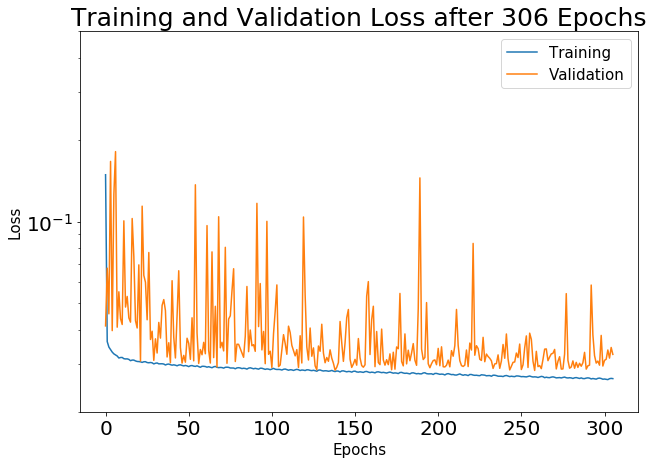

In [22]:
plot_history_from_list(loss[:306],val_loss[:306],False,save_folder_name,logscale=True,ymin=0.02,ymax=0.5)

In [42]:
print(min(val_loss))
print(val_loss.index(min(val_loss)))

0.0283716622267
258


In [47]:
loss = [0.1544314655046719, 0.036301116283124824, 0.03452592794057514, 0.03390665456486407, 0.033158303621767964, 0.03270446252086028, 0.03235547018968686, 0.03192577261678392, 0.031913637110244315, 0.031804847952721677, 0.03161397931069651, 0.03136120696293076, 0.0313335605136407, 0.030950066692749828, 0.031163513476337428, 0.031073637361114174, 0.03084029127577208, 0.03085605336786416, 0.030829922360497215, 0.030579683291855, 0.030726496542978324, 0.030738289431404463, 0.03049684410725903, 0.030396849973365468, 0.030511930379230678, 0.030218389425097893, 0.03044029956001863, 0.03039590361665915, 0.03027174794936035, 0.030079163474748354, 0.030193689714247872, 0.029904086397208283, 0.030099691447404903, 0.030126554837847222, 0.030006545051013814, 0.029856198939164882, 0.029911202712838245, 0.02969598601562757, 0.029827271921228925, 0.029955397241043197, 0.029787136978548442, 0.029663817494524646, 0.029729168654311543, 0.02949905601717904, 0.029645320914974013, 0.029741796192365864, 0.029542591235740344, 0.02949796898059319, 0.029512196296502972, 0.029309926620961275, 0.029518096915913884, 0.029567155095504012, 0.029440847859255492, 0.02930530662330829, 0.029439860390200412, 0.02924396044768103, 0.029429646993120562, 0.02947518483220392, 0.029340055973272834, 0.029211356309939457, 0.029283245575620176, 0.029105697595202772, 0.029281631738016532, 0.029346427019791562, 0.02921945979795891, 0.02906155850190408, 0.029212451866160026, 0.029051298232592476, 0.0292674992186116, 0.029241011306842223, 0.0290715497064466, 0.028954029106993663, 0.029017965517305195, 0.028847500104077526, 0.02905195936899363, 0.02910603857949717, 0.02897695543094794, 0.02884894770031594, 0.028903076842219377, 0.02878926625927311, 0.028999433776111205, 0.029070223794602855, 0.028857316536320565, 0.02872844916170957, 0.02883571793281211, 0.028658640735882115, 0.028948825057027606, 0.02896397716963085, 0.02879788272614857, 0.028693222353747428, 0.02877520271571757, 0.028569155179169477, 0.028819989293510352, 0.028852254681852395, 0.02867993925821317, 0.028574529880195612, 0.028663005356179844, 0.028472350230006504, 0.028786696139573673, 0.028726136512021584, 0.028641568771566962, 0.028449807683743954, 0.028516471272156414, 0.028399128283978368, 0.028684919533411332, 0.02870638809950558, 0.02849879987373489, 0.02842572563597916, 0.028420974525298195, 0.028321713666804384, 0.028531558453930742, 0.028598735918898274, 0.028373412185018706, 0.028307810595420608, 0.028438579464449384, 0.028164875703754973, 0.02842710653557245, 0.028475302456590624, 0.028353063319534123, 0.02823934104132175, 0.028247854330233548, 0.028201365015841, 0.028456194389465814, 0.02848096012783406, 0.028294112070642634, 0.028157834126481256, 0.028175474989719056, 0.028077474757891865, 0.028304109100537714, 0.028277628842359605, 0.02814542969059766, 0.028035512755162834, 0.028168316845807135, 0.027973358080915434, 0.028140324332639164, 0.02819428081407043, 0.02805502687643327, 0.027967164721086443, 0.028054924494345934, 0.02786139665668387, 0.028060038255939095, 0.02812638363043176, 0.027997528591988438, 0.027814324550362632, 0.027947071914060675, 0.027812419480341598, 0.028056911741750356, 0.02809075343903372, 0.02788161086557371, 0.02773923719824857, 0.027822911257236047, 0.027678205290846473, 0.027976468013910103, 0.02798769608288282, 0.027843164213994902, 0.027698298643254467, 0.027793936212146243, 0.027631241757866794, 0.027814448650529303, 0.027919425599730187, 0.027739308037674153, 0.02754936219909673, 0.027708790298139375, 0.027527200701075543, 0.0276573383680227, 0.02778478716871147, 0.027634479535828108, 0.027501337433681734, 0.027568346369658023, 0.027417562782884285, 0.0276227907336871, 0.02773133626375848, 0.027486102164825627, 0.027404791041189598, 0.027513586202191107, 0.027321594076625676, 0.027536596583948462, 0.027622511943661436, 0.02743541622491693, 0.02736257703242828, 0.027442969032285543, 0.02731793628794754, 0.027454185111270974, 0.0275607313711947, 0.027270463629251902, 0.02723819447977423, 0.027337452362344014, 0.027214389402006538, 0.027352456493920253, 0.027412083224327134, 0.027235634273106726, 0.027139166768649504, 0.02722494640140169, 0.027104905232893103, 0.027348263883419453, 0.02732101828410043, 0.027178669089570225, 0.027055614299047532, 0.02715978056399429, 0.02702836086885733, 0.027238499800590676, 0.02723382244965039, 0.027075307029802733, 0.027009880381023713, 0.02710890661965451, 0.026918339371118184, 0.02711017014589926, 0.027093720975206546, 0.026979367819890448, 0.02694046488059888, 0.026975903455143887, 0.026794702378104503, 0.027031358492767017, 0.027013328672166364, 0.026919645000896393, 0.0267851915837419, 0.026987320271481267, 0.02670783260939401, 0.026928497142596316, 0.026915310576203978, 0.026852308018969505, 0.026789511773268323, 0.026884310291893622, 0.026681634145858783, 0.026888055080442595, 0.02689562740561371, 0.026663809547931374, 0.02663056850201434, 0.02669804127116619, 0.026666169231684096, 0.026806585069066028, 0.026803885503929308, 0.02663243399980845, 0.02653554429942362, 0.026693204326412808, 0.026432515796011306, 0.02673922154382154, 0.02661781168056732, 0.02662978278439121, 0.026502547100812013, 0.02657719567546583, 0.026413493225665798, 0.02659116025891445, 0.02662206281747526, 0.026422254925666227, 0.026392920304406257, ]
val_loss = [0.0440733136856, 36.5785320006, 0.041681992897, 0.110727549718, 484.953578915, 0.0764663486608, 0.13504730893, 0.691772745678, 0.157475656445, 0.0494146659362, 0.101400453541, 0.122050244082, 0.0442380765409, 0.188147223833, 0.0351931567226, 0.0365071905328, 0.0448952966613, 0.0494096914464, 0.0365570431384, 0.0394449778314, 0.0324838547528, 0.062034978104, 0.124626405309, 0.033602806697, 0.0349881010601, 0.0627845779872, 0.0391879477939, 0.0965868812407, 0.0325902632572, 0.0355871394254, 0.0475170197164, 0.0350822602546, 0.0470356161311, 0.0478253990807, 0.0506621522359, 0.0313147110576, 0.0425444585965, 0.0343639938444, 0.0467683636327, 0.0897248477607, 0.0328860970476, 0.0358550470723, 0.0664085697871, 0.0433746503977, 0.0308996080325, 0.0965723975941, 0.0330919437802, 0.0455881844138, 0.0315978499835, 0.0487802674041, 0.0488342631112, 0.0711031867139, 0.0298864533208, 0.0374929590533, 0.0369646138723, 0.0307380988309, 0.0304991791548, 0.0305882526229, 0.0537091942898, 0.0303747663293, 0.0294306599383, 0.0378121585507, 0.0323408596985, 0.0343622061113, 0.0321044117784, 0.0455115159539, 0.0419361462031, 0.0430495414927, 0.0359316782838, 0.0294511802264, 0.0318391074135, 0.0409486610501, 0.0320154865615, 0.0309428665584, 0.0292735907744, 0.0344882364622, 0.0439187218884, 0.0306975915936, 0.0389582724896, 0.0332269341725, 0.0374561349078, 0.0315426017689, 0.0294928320876, 0.0300705296066, 0.0308095054728, 0.0306854927093, 0.0374766025884, 0.0498115435547, 0.0297091165591, 0.0325640838695, 0.0326710371062, 0.0374443949672, 0.0619290069714, 0.0586068043984, 0.0311971229051, 0.0305879038037, 0.0325356898603, 0.031309759794, 0.0310311624867, 0.0379523695121, 0.0317787306804, 0.0326707452278, 0.0324082176833, 0.0444742558128, 0.0365978488641, 0.0543955020742, 0.03029529345, 0.0299834433358, 0.0570698617094, 0.0387460514467, 0.0345546421175, 0.0326135330808, 0.0321949501539, 0.0623265301546, 0.0300597443892, 0.029468846798, 0.0407797131484, 0.0413888350779, 0.0401371428099, 0.0289832343867, 0.0385409333126, 0.0319262146314, 0.032663689852, 0.0570816575326, 0.0372694346844, 0.0306696056418, 0.0478541071352, 0.03111223625, 0.0351600430349, 0.0783223756949, 0.0339856241908, 0.0422510344672, 0.032803535425, 0.0383847679305, 0.0319674907927, 0.0305857497902, 0.0364426218912, 0.0303299638719, 0.0358489619243, 0.0285023447236, 0.0427555938395, 0.0330827179653, 0.0307180903237, 0.0423192739914, 0.0291396654595, 0.0369077256233, 0.0335347294428, 0.0305615131346, 0.0684081204301, 0.0300433563195, 0.0301496049206, 0.033848350679, 0.032475663495, 0.0293376870106, 0.0298436195773, 0.0326610324948, 0.045943201418, 0.0318942661985, 0.0325906456783, 0.0298083902012, 0.0307381590884, 0.0350417331524, 0.0473294236388, 0.0304649224849, 0.0367954097062, 0.0314571403264, 0.0362938473808, 0.0365903923722, 0.0341804055896, 0.0309760622335, 0.0296604516953, 0.0302399945401, 0.0365629082531, 0.0332650240635, 0.0306029012065, 0.0296884663464, 0.0294353608399, 0.053262375801, 0.0288275922965, 0.0299368019835, 0.049190790684, 0.0358463975659, 0.046883047851, 0.0290622983455, 0.032786526819, 0.0399140841031, 0.0305419990518, 0.0335842736727, 0.0291209173203, 0.0307844588814, 0.0357354324214, 0.0316235614163, 0.0334757321938, 0.0477032530607, 0.0356036536878, 0.0296395449642, 0.0319988439414, 0.031924037588, 0.0297322856511, 0.0299520615406, 0.0305973478116, 0.0316253157899, 0.0289456148692, 0.0337417148039, 0.0314498468543, 0.0332811821602, 0.0312396712601, 0.0323572017886, 0.0318669246992, 0.0419428404412, 0.0322314287749, 0.02973344439, 0.0303570301269, 0.0319441602845, 0.0318793303689, 0.0351812805292, 0.0309871675879, 0.0295902636537, 0.0356558273677, 0.0295423630268, 0.0292177839649, 0.035190203844, 0.0306351826796, 0.0297728274046, 0.0344443499631, 0.0372342363809, 0.0312343462709, 0.0334841389264, 0.040631915794, 0.0299017560574, 0.029987208743, 0.0348834784484, 0.0304496309638, 0.0348612888139, 0.0339789718719, 0.0301597914167, 0.0334301076453, 0.0421163020535, 0.031329749473, 0.0334135081991, 0.0296410942717, 0.048338421221, 0.0309571036994, 0.0308351036074, 0.0326723159465, 0.0333805895444, ]

In [48]:
loss = loss + [0.026499890752953153, 0.026306550829410566, 0.026586352703056055, 0.026526854947738192, 0.02634764683304202, 0.026274354203834997, 0.026419053613153325, 0.026218435106622487, 0.02650828657524238, 0.02645960983734582, 0.026313777906259054, 0.026193888902100816, 0.02629275476052195, 0.02615507826461467, 0.026370726782075523, 0.02639632135750013, 0.02615178468787681, 0.0261710396673977, 0.026302656780406056, 0.02607763803927565, 0.026287849414629406, 0.026324303285123026, 0.026142347345924574, 0.0260836493425435, 0.02617374480540383, 0.026025473282397616, 0.026254548942786397, 0.026210824537236728, 0.026070357088633627, 0.02596668264855136, 0.02619368224121312, 0.025967443814071234, 0.026152944767889257, 0.02614681559451671, 0.025985214238619412, 0.025898856230616243, 0.02598548589381654, 0.025866001902596598, 0.026099555955466903, 0.02606495469122989, 0.025928580278148438, 0.025816414650317428, 0.025994783301108118, 0.025736497701234474, 0.026018761139181664, 0.026004882915720326, 0.025837907328129472, 0.025731597753512973, 0.025858822484545713, 0.025660778265675376, 0.02597476527679031, 0.02592662356571614, 0.025700947144444476, 0.025675886688875042, 0.025752705978031372, 0.02560518011813876, 0.02588671878813266, 0.025824292697501815, 0.025688804781332574, 0.02559007549890291, ]
val_loss = val_loss + [0.0422475228334, 0.0308774103395, 0.0376479669096, 0.0351451414727, 0.0313777727211, 0.0290592581636, 0.0303502598203, 0.030271278382, 0.0307795357931, 0.0356605129701, 0.0297343361857, 0.0313336030648, 0.031932677874, 0.0296175816687, 0.0363787759936, 0.0308195097961, 0.03220688368, 0.0331318054637, 0.0391661891075, 0.029051346767, 0.0328206403333, 0.0319642976673, 0.0298059638842, 0.0324210927856, 0.0318582499596, 0.0299253610505, 0.0299393115264, 0.0327373337804, 0.0327711938704, 0.0303918160266, 0.0319515612732, 0.0427635811857, 0.0320345625365, 0.0558455121214, 0.0351123852518, 0.0340721998342, 0.0407815126219, 0.0321636465274, 0.0325628672845, 0.0295464575908, 0.0387027695967, 0.0304555266015, 0.0388711229684, 0.0307385109251, 0.0294480335989, 0.0420606056688, 0.0296907186467, 0.0297725250522, 0.0302397047476, 0.0329524945972, 0.0309770830094, 0.0328129708702, 0.029938365675, 0.0438903417255, 0.031120084557, 0.0303868288772, 0.0331555916807, 0.0306384586791, 0.0327439342782, 0.0349153657391, ]

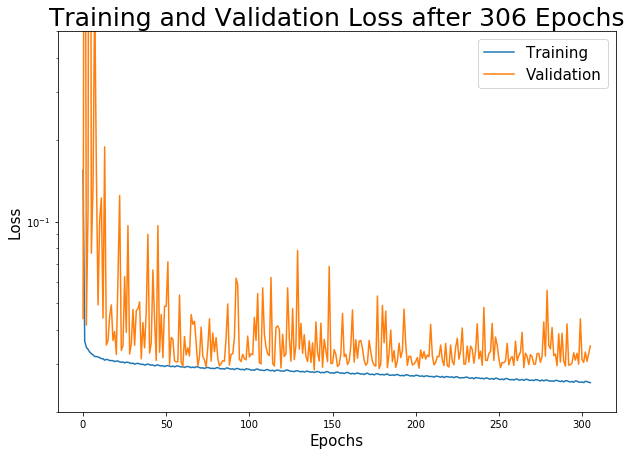

In [50]:
plot_history_from_list(loss,val_loss,save,save_folder_name,logscale=True,ymin=0.02,ymax=0.5)

(array([ 0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 7 Text yticklabel objects>)

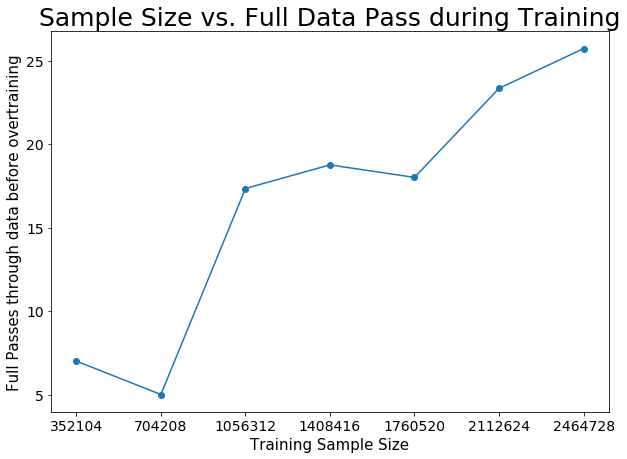

In [16]:
plt.figure(figsize=(10,7))
training_samples = 352104
samples = [training_samples*1, training_samples*2, training_samples*3, training_samples*4, training_samples*5, training_samples*6, training_samples*7]
#overtrained = [20/1., 30/2., 70/3., 120/4., 150/5., 200/6., 290/7.]
overtrained = [7/1., 10/2., 52/3., 75/4., 90/5., 140/6., 180/7.]
#plt.errorbar(samples,overtrained,yerr=20,marker='o',capsize=10)
plt.plot(samples,overtrained,marker='o')
plt.xlabel("Training Sample Size",fontsize=15)
plt.ylabel("Full Passes through data before overtraining",fontsize=15)
plt.title("Sample Size vs. Full Data Pass during Training",fontsize=25)
plt.xticks(samples,fontsize=14)
plt.yticks(fontsize=14)

(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <a list of 10 Text yticklabel objects>)

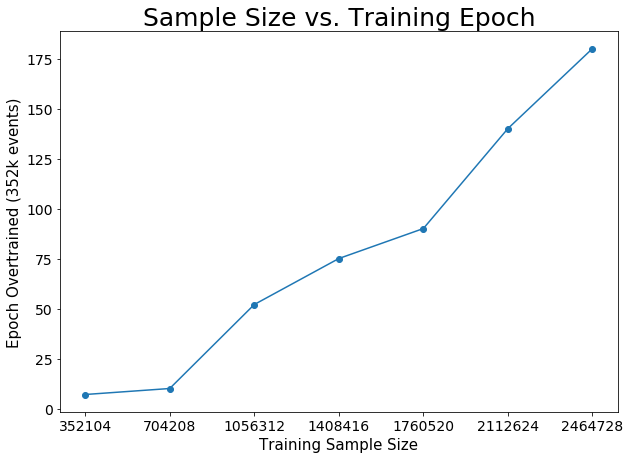

In [17]:
plt.figure(figsize=(10,7))
training_samples = 352104
samples = [training_samples*1, training_samples*2, training_samples*3, training_samples*4, training_samples*5, training_samples*6, training_samples*7]
#overtrained = [20/1., 30/2., 70/3., 120/4., 150/5., 200/6., 290/7.]
overtrained = [7., 10., 52., 75., 90., 140., 180.]
#plt.errorbar(samples,overtrained,yerr=20,marker='o',capsize=10)
plt.plot(samples,overtrained,marker='o')
plt.xlabel("Training Sample Size",fontsize=15)
plt.ylabel("Epoch Overtrained (352k events)",fontsize=15)
plt.title("Sample Size vs. Training Epoch",fontsize=25)
plt.xticks(samples,fontsize=14)
plt.yticks(fontsize=14)

In [56]:
loss1 = [0.5408013028539405, 0.3041269557210749, 0.25605212664971916, 0.2324059854813793, 0.21874178467165578, 0.21070605054001068, 0.20382432329498426, 0.1981346168642485, 0.19398596191974904, 0.1904336628680875, 0.18709957114761744, 0.18459852797324244, 0.1819962612945669, 0.17995059070542224, 0.17814828742950564, 0.17636199412876732, 0.17504015755112598, 0.17358142477110344, 0.1721076594490946, 0.17148849178686704, 0.17044797297448583, 0.16901871320713535, 0.1685758573717204, 0.16723367929646435, 0.1666129324176514, 0.16586126560583828, 0.16518443066752345, 0.16428024240213693, 0.16345713128882927, 0.1631435410315428, 0.16274594593705757, 0.16193472191447464, 0.16111836485638054, 0.16052978833247888, 0.16019733509837578, 0.1595444887733283, 0.1589345874840094, 0.15866781019341508, 0.15786931509566568, 0.15712339913584214, 0.1566447167221815, 0.1568295455200743, 0.15574306274911306, 0.15586779949452248, 0.1551855041878302, 0.15471072590492407, 0.15470600213350102, 0.15409568347847688, 0.15378256954502037, 0.15351986330922535, 0.15302802480213842, 0.15262380452366436, 0.15241908695557335, 0.15199481338484325, 0.1513158209498546, 0.1515238999934836, 0.15088460585518831, 0.15035994574436684, 0.15042921364875922, 0.15003647343141652, 0.14955456334141587, 0.14925577454150596, 0.149036983488762, 0.14841126089323423, 0.14884667120213171, 0.1480407953525476, 0.14799043941187331, 0.14775205580710804, 0.1468839459633207, 0.1469130405876447, 0.14682099294277587, 0.14658580960390022, 0.1458628076402467, 0.14599194318070716, 0.14544572010142717, 0.14560607561040181, 0.14514341491287222, 0.14515594724984596, 0.14440829607974837, 0.1446282208261257, 0.14369014194159252, 0.14333996861634543, 0.14354188996816786, 0.1432329161307913, 0.14275015447983153, 0.142755141547454, 0.1423534393814377, 0.14207992950534756, 0.14216945287679328, 0.14196737786005606, 0.14131577862770747, 0.1414975543016214, 0.14089778993299834, 0.14057199101299203, 0.14007714833863877, 0.14007305701582698, 0.13974237300845752, 0.14008878364551544, 0.13956184883236522, 0.1395427033064401, 0.13928424500224337, 0.13895269624592013, 0.13861382834170194, 0.1389688299455409, 0.1379892737895688, 0.1379521006932575, 0.13770995356286275, 0.13741637111035784, 0.13738699468469265, 0.13693782620530806, 0.1367667840319868, 0.1366028687592395, 0.13696469867303085, 0.13638475752551116, 0.1355977860513838, 0.13604250657838274, 0.13542047493999923, 0.1353435524860693, 0.13516147314349086, 0.1345529543595899, ]
energy_loss1 = [0.11697724, 0.02265104, 0.020253079, 0.019585555, 0.01906908, 0.018631153, 0.01849887, 0.018323451, 0.018033495, 0.018027747, 0.017888576, 0.017736094, 0.017747443, 0.017661558, 0.017481228, 0.017495077, 0.017497923, 0.01736049, 0.017384872, 0.017330123, 0.017174749, 0.017243769, 0.017203473, 0.017107505, 0.01717789, 0.017138124, 0.017026028, 0.017025862, 0.01701937, 0.016923692, 0.016995573, 0.016956106, 0.016922485, 0.016910437, 0.016919153, 0.01685347, 0.016889134, 0.016854772, 0.016766226, 0.016795935, 0.016862677, 0.016710654, 0.01676252, 0.016722297, 0.016593335, 0.016717108, 0.016711928, 0.016650215, 0.016674956, 0.016677907, 0.016568527, 0.0166733, 0.016678778, 0.016557511, 0.016616613, 0.016626759, 0.016539654, 0.01657764, 0.016596101, 0.016477395, 0.016541231, 0.016546218, 0.016475338, 0.016521335, 0.01655163, 0.016395785, 0.01647092, 0.016496006, 0.016410917, 0.01649554, 0.016503157, 0.016407656, 0.016479827, 0.016473226, 0.016329853, 0.01643669, 0.016382275, 0.016363947, 0.016408278, 0.016404593, 0.016340615, 0.016416019, 0.0163888, 0.016313648, 0.01640216, 0.016378196, 0.016337, 0.016406404, 0.016419383, 0.016321812, 0.016364701, 0.01637138, 0.016280558, 0.016355729, 0.016337465, 0.01625206, 0.016317833, 0.016381538, 0.01625837, 0.016307358, 0.01634688, 0.01624406, 0.016303068, 0.01631486, 0.01622659, 0.016325392, 0.016308665, 0.016228389, 0.016318168, 0.016276294, 0.016228644, 0.016302854, 0.016310807, 0.01622, 0.016313277, 0.01630578, 0.016230991, 0.016275031, 0.01629775, 0.016209755, ]
zenith_loss1 = [0.4237421, 0.28146854, 0.23577943, 0.21282807, 0.19966325, 0.1920914, 0.185321, 0.17981659, 0.17596118, 0.17240675, 0.1692102, 0.16686326, 0.16423602, 0.1622878, 0.16067694, 0.15887356, 0.15754767, 0.1562268, 0.15472633, 0.1541472, 0.1532767, 0.15178268, 0.15136772, 0.15012142, 0.14943476, 0.14871846, 0.14815044, 0.14725424, 0.1464371, 0.14623304, 0.14573967, 0.1449781, 0.14419895, 0.14361697, 0.14326829, 0.14269093, 0.1420428, 0.14182363, 0.14109813, 0.14032696, 0.13979492, 0.14012338, 0.13897699, 0.1391475, 0.13859895, 0.1379963, 0.13798968, 0.13745439, 0.137109, 0.13682991, 0.13646118, 0.13594691, 0.13573875, 0.1354489, 0.13469148, 0.13490225, 0.13435298, 0.133768, 0.13383079, 0.13356648, 0.13301322, 0.13271376, 0.1325568, 0.1319022, 0.13229488, 0.13164563, 0.13152097, 0.13126041, 0.13047333, 0.13040933, 0.13031588, 0.1301755, 0.12937848, 0.12952916, 0.12911874, 0.12915726, 0.12876315, 0.12878753, 0.12800016, 0.12822525, 0.12734845, 0.12692103, 0.12715536, 0.12691304, 0.12635602, 0.1263814, 0.12601629, 0.12567085, 0.12574275, 0.12563874, 0.12494796, 0.12511538, 0.124619275, 0.124214366, 0.123747416, 0.123819694, 0.12342923, 0.12370524, 0.12329259, 0.123229, 0.12293057, 0.12270407, 0.12230959, 0.122649394, 0.12175909, 0.121625565, 0.12140178, 0.12119196, 0.12106271, 0.12066514, 0.120542035, 0.120293476, 0.120648354, 0.120157406, 0.11929243, 0.11973517, 0.11919416, 0.119069695, 0.1188596, 0.11834201, ]
val_loss1 = [0.362541934276, 0.407150563638, 1.01825298665, 0.280873256898, 0.232875367633, 0.200653352808, 0.242422012053, 0.249064301705, 0.201711729645, 0.231072777633, 0.246413028582, 0.180889564691, 0.230716511737, 0.233921863752, 0.223676388581, 0.2013915635, 0.173093187612, 0.220850520757, 0.192604444254, 0.204782070978, 0.177540750982, 0.198085667422, 0.177511077522, 0.17496718309, 0.167809379146, 0.159825331866, 0.160325094576, 0.186991981403, 0.159111280474, 0.158672301383, 0.156400972506, 0.160522866544, 0.192483361893, 0.187756856369, 0.183186196156, 0.194151604439, 0.181348950157, 0.15298392912, 0.223775070632, 0.152887303057, 0.154830797415, 0.185232064837, 0.15704733884, 0.15575705353, 0.161402441807, 0.15077871282, 0.173397957787, 0.182015839049, 0.185868539178, 0.162383492708, 0.159298407986, 0.15801425729, 0.19371113186, 0.260495585173, 0.156065332417, 0.159181431033, 0.163856199893, 0.21597047222, 0.157680615226, 0.161721680717, 0.191318954555, 0.149867259606, 0.162684792874, 0.154556140855, 0.152229071274, 0.147744034179, 0.15364323497, 0.158477250085, 0.171205276315, 0.165401911839, 0.171509875561, 0.151878122888, 0.165559431814, 0.157309036763, 0.171365673116, 0.147035567023, 0.166025850088, 0.148860761987, 0.150648656674, 0.15989209264, 0.160538546803, 0.163905612219, 0.198750499078, 0.184615514781, 0.14852046972, 0.149893989203, 0.150693845659, 0.18468666402, 0.181719390187, 0.148124980249, 0.182048276672, 0.257312962271, 0.177591418805, 0.153626400284, 0.151293239334, 0.158702281244, 0.15240357766, 0.15265297253, 0.164722099808, 0.154913636494, 0.148463104627, 0.331310601069, 0.155357534698, 0.152281974191, 0.166530653051, 0.155365504095, 0.171555742616, 0.15373340508, 0.188091438746, 0.147966048139, 0.157030058055, 0.160314924369, 0.152330982964, 0.149166888724, 0.147765654512, 0.149392354886, 0.150339741496, 0.152259168571, 0.155407798184, 0.165859144204, ]
val_energy_loss1 = [0.0295332726091, 0.0689845383167, 0.13907790184, 0.0294351167977, 0.0250295829028, 0.0191552862525, 0.0222218614072, 0.0490244664252, 0.0194450076669, 0.0380381196737, 0.0263366512954, 0.018190830946, 0.024965878576, 0.0304207783192, 0.0342132858932, 0.0219756383449, 0.0187275391072, 0.0473568402231, 0.0203462857753, 0.033208809793, 0.017655480653, 0.0193247292191, 0.0196721814573, 0.0219282787293, 0.0170555803925, 0.0160942487419, 0.0186636522412, 0.0202019419521, 0.0184244699776, 0.0159867014736, 0.0159380584955, 0.0191030744463, 0.0204278398305, 0.0268174950033, 0.021776791662, 0.0178944692016, 0.0171599183232, 0.0163210984319, 0.0267710238695, 0.0166336447001, 0.0165992695838, 0.0211268533021, 0.0208474099636, 0.0169485826045, 0.0211050771177, 0.015381959267, 0.029008295387, 0.033256739378, 0.0196864120662, 0.0241811163723, 0.0176110826433, 0.0165372677147, 0.0434417203069, 0.0339990332723, 0.0160179119557, 0.0204453598708, 0.0193620342761, 0.0270492415875, 0.0238212607801, 0.0221303477883, 0.0225398633629, 0.0164321623743, 0.0207485351712, 0.0159823484719, 0.0175181664526, 0.0163976009935, 0.0159564949572, 0.0215884614736, 0.0190712325275, 0.0168896391988, 0.0233419481665, 0.0173624195158, 0.0284412857145, 0.0179859157652, 0.0239350162446, 0.0154339848086, 0.0231079757214, 0.0161589477211, 0.0154518587515, 0.0178320631385, 0.0164589378983, 0.0196052826941, 0.0196081195027, 0.0316056571901, 0.0167152192444, 0.015679769218, 0.0180199276656, 0.0294448267668, 0.0186371449381, 0.0155980288982, 0.0181939490139, 0.0199341252446, 0.0197680145502, 0.0157915931195, 0.0166217721999, 0.016487179324, 0.0209235455841, 0.016273971647, 0.0213225204498, 0.0191697087139, 0.0166313815862, 0.0326169840991, 0.0195250865072, 0.0166329182684, 0.0210301931947, 0.0193097535521, 0.0242196787149, 0.0154846413061, 0.0308681186289, 0.0156139349565, 0.0183306541294, 0.0224431157112, 0.0159444790334, 0.0181797351688, 0.0157821718603, 0.0154537074268, 0.0155888069421, 0.0174662675709, 0.0164069235325, 0.0250281877816, ]
val_zenith_loss1 = [0.332973897457, 0.33818846941, 0.879303216934, 0.251420736313, 0.207884788513, 0.181460008025, 0.22021342814, 0.200044095516, 0.182241424918, 0.1930436939, 0.22008523345, 0.162670016289, 0.205748051405, 0.203533619642, 0.189444363117, 0.179421246052, 0.15439710021, 0.173465549946, 0.172252744436, 0.171553313732, 0.159876197577, 0.17876316607, 0.15784817934, 0.152999043465, 0.150754079223, 0.143737465143, 0.141632437706, 0.166800230742, 0.140700891614, 0.14267192781, 0.140472009778, 0.141427218914, 0.172014907002, 0.160957172513, 0.161402985454, 0.176260918379, 0.164179265499, 0.136683166027, 0.196963518858, 0.136263608932, 0.138228073716, 0.164073184133, 0.136198028922, 0.13881611824, 0.140273600817, 0.135406926274, 0.14441666007, 0.148733526468, 0.166172131896, 0.138205826283, 0.14166161418, 0.141480669379, 0.150276422501, 0.226497292519, 0.140059560537, 0.138757064939, 0.144453108311, 0.188942268491, 0.133891537786, 0.139557883143, 0.168778285384, 0.133446767926, 0.141896635294, 0.138578727841, 0.134730502963, 0.131319925189, 0.137688472867, 0.136894777417, 0.152095362544, 0.148517400026, 0.14819163084, 0.134486570954, 0.137126848102, 0.139349922538, 0.147404640913, 0.131608948112, 0.142923355103, 0.132693275809, 0.135194405913, 0.142083376646, 0.144050598145, 0.14430603385, 0.179170265794, 0.152970641851, 0.13181489706, 0.134231820703, 0.132646292448, 0.155250757933, 0.163058832288, 0.132507577538, 0.163855031133, 0.237405687571, 0.15776771307, 0.137848198414, 0.134682640433, 0.142186418176, 0.131485700607, 0.136396661401, 0.143383145332, 0.135739594698, 0.13186044991, 0.298706948757, 0.135837063193, 0.135663285851, 0.145459264517, 0.136064738035, 0.147356331348, 0.138230577111, 0.157225385308, 0.132369697094, 0.138673007488, 0.137865617871, 0.136395365, 0.130971372128, 0.131983324885, 0.133950337768, 0.134735554457, 0.134790599346, 0.139013022184, 0.140796557069, ]

In [57]:
len(loss1)

120

In [58]:
loss2 = [0.5838404969256886, 0.3068418699626799, 0.2592992261235811, 0.23730496482951016, 0.22328020153853495, 0.21475939061027044, 0.2064571674828074, 0.20057375948708922, 0.19565039393319106, 0.19057023953572685, 0.1873645681821498, 0.1845078440396747, 0.18165230675581517, 0.17943299097709414, 0.17765137043008875, 0.1760230837255736, 0.17461470139343532, 0.17317883696408284, 0.1716092460347506, 0.17084191594596518, 0.16975991234701582, 0.16826418487209116, 0.16742178573181968, 0.1665239824115477, 0.16544355729343846, 0.16517717597046624, 0.16405284896069272, 0.16287150042331042, 0.16272952189905382, 0.16171791899199459, 0.16107794792638538, 0.16090062768400293, 0.15994581396043625, 0.1595845422098178, 0.1589882709555589, 0.15848471935066608, 0.15784056544460295, 0.15734639673555037, 0.15690435045455223, 0.15625635625669698, 0.15636359257143007, 0.15590936684686965, 0.15505174057258578, 0.1548044829614422, 0.154596022671451, 0.15394965950363798, 0.1540153407421621, 0.1532762605252265, 0.1526515402410927, 0.1526907542671799, 0.15225182992868064, 0.15153211441390582, 0.15180836053909263, 0.15101750647772605, 0.1504924089256396, 0.1506850392925537, 0.1503642563021013, 0.149406322980044, 0.14981450882082392, 0.1489221259435347, 0.1485610112106074, 0.14890777238680059, 0.14851425776970142, 0.147782584103501, 0.14775962818973634, 0.14717283000977407, 0.14710267744950273, 0.14650596349843586, 0.14675023306007529, 0.1457460384746925, 0.14618285320926028, 0.14551536062358508, 0.14536044093887363, 0.1449468523710925, 0.14489606628385257, 0.1442827509483182, 0.14427201310879023, 0.14409216501141794, 0.143601303056601, 0.14374421579920174, 0.14357702291215368, 0.14289240174638393, 0.1429602573874277, 0.14238836709438982, 0.14189905554864438, 0.14206748024005877, 0.14177347719551112, 0.1414040795971508, 0.14093412538288086, 0.141179735661286, 0.1406058450947885, 0.14036860496745754, 0.1405584405075281, 0.14004094951017493, 0.14009877119361688, 0.13961949821439482, 0.13944707218390184, 0.1391524303568124, 0.13925253714679567, 0.138565151687422, 0.13843941088380968, 0.13824656387281517, 0.13779219279669128, 0.13778781092495682, 0.13780550790749252, 0.13725154016579433, 0.1371055861149798, 0.13709141208880693, 0.13631329570755937, 0.1364470349342801, 0.1364523136031577, 0.13586685022041955, 0.13573395183634787, 0.13551423916253988, 0.1351418075955518, 0.13510613140935895, 0.1354941781679183, 0.13497035973428578, 0.13476451958430968, 0.13497388787069656, ]
energy_loss2 = [0.13455778, 0.023192922, 0.020290771, 0.019579258, 0.019148692, 0.018756436, 0.018538415, 0.018325819, 0.018027153, 0.018054357, 0.017875873, 0.01772793, 0.01774152, 0.017670065, 0.01751938, 0.01749591, 0.01748072, 0.017327545, 0.01740769, 0.01735098, 0.017245794, 0.017252337, 0.017222965, 0.017110115, 0.017127998, 0.017150816, 0.017068941, 0.017072394, 0.017002447, 0.016972592, 0.017009512, 0.016977737, 0.016852688, 0.016930697, 0.016920594, 0.016764842, 0.016835377, 0.0168487, 0.016724003, 0.016830195, 0.01678693, 0.016765468, 0.01681442, 0.016738363, 0.016668418, 0.016717508, 0.016699042, 0.016659709, 0.016656008, 0.016671186, 0.016645834, 0.016641079, 0.016599689, 0.016539892, 0.016607797, 0.016622407, 0.01651452, 0.016624574, 0.016573798, 0.016496953, 0.01657297, 0.016576845, 0.016480736, 0.016532423, 0.016471695, 0.016444335, 0.01652269, 0.01650349, 0.016417006, 0.016521256, 0.016468264, 0.0164001, 0.016452303, 0.01645896, 0.016376816, 0.016460981, 0.016448552, 0.01638452, 0.016385986, 0.016386062, 0.01637301, 0.016353091, 0.016376521, 0.016329758, 0.016392939, 0.016441634, 0.016294863, 0.016370218, 0.016342336, 0.016297933, 0.016371382, 0.016343951, 0.016287303, 0.016339174, 0.01636433, 0.016260268, 0.016339727, 0.016329728, 0.016228154, 0.016299233, 0.016280927, 0.016274968, 0.016285645, 0.016320191, 0.016203873, 0.016295224, 0.01626909, 0.01622814, 0.016271008, 0.016341865, 0.01621005, 0.016280873, 0.016315969, 0.01624909, 0.016287094, 0.016237546, 0.016189378, 0.01623515, 0.01624385, 0.016162425, ]
zenith_loss2 = [0.44920632, 0.28362805, 0.23902844, 0.21772115, 0.20414157, 0.19599147, 0.18791361, 0.18223634, 0.17763597, 0.17252159, 0.16948573, 0.16677934, 0.1639132, 0.16175869, 0.16013181, 0.1585212, 0.15713617, 0.15585928, 0.15421726, 0.15350206, 0.1525077, 0.1510264, 0.15020694, 0.14942564, 0.14831747, 0.14802642, 0.14696951, 0.14580137, 0.14572777, 0.14474964, 0.14408013, 0.1439176, 0.14310636, 0.14264342, 0.14207537, 0.14173152, 0.1410083, 0.140494, 0.1401742, 0.13942921, 0.13958156, 0.13915297, 0.13823847, 0.1380677, 0.1379269, 0.13723713, 0.1373067, 0.13662392, 0.1359901, 0.1360292, 0.13560824, 0.13489805, 0.13522375, 0.13448377, 0.13387856, 0.13406181, 0.133846, 0.13277623, 0.13323654, 0.13243178, 0.13199341, 0.13234015, 0.13204186, 0.13125402, 0.13129345, 0.13071227, 0.13058181, 0.1300081, 0.13034089, 0.12922774, 0.12971447, 0.12911835, 0.12890507, 0.12848696, 0.1285184, 0.12781933, 0.12781402, 0.12771368, 0.12720425, 0.12736446, 0.12720902, 0.12654363, 0.12658629, 0.12605706, 0.12550737, 0.12562457, 0.12547633, 0.12502809, 0.12459217, 0.124888904, 0.12424189, 0.12402969, 0.124271564, 0.12371067, 0.12373755, 0.12334746, 0.123109415, 0.12282292, 0.123045616, 0.12225771, 0.122154295, 0.12197666, 0.12151342, 0.12146966, 0.121601254, 0.120954804, 0.12083506, 0.1208588, 0.12003848, 0.12011077, 0.1202342, 0.11958899, 0.11942053, 0.11926009, 0.118840836, 0.11887363, 0.11930533, 0.118740514, 0.118525945, 0.118817195, ]
val_loss2 = [0.360527758132, 0.425071524177, 0.392783204163, 0.286843964002, 0.668711482808, 0.319121173685, 0.208821348222, 0.231137497003, 0.215980824928, 0.191138142589, 0.197589066357, 0.259714516957, 0.281829258768, 0.200422852594, 0.236265970165, 0.224991364619, 0.174740472629, 0.175124496665, 0.198698342787, 0.221082486955, 0.195081527899, 0.189231543814, 0.201307291575, 0.168336741775, 0.178550369667, 0.159882988004, 0.168774901377, 0.184115796606, 0.202040062155, 0.193772575012, 0.181278981525, 0.155505070203, 0.257500165435, 0.155513462713, 0.173367849945, 0.155255292253, 0.181415359049, 0.172510750335, 0.207447863523, 0.166728364457, 0.192355167565, 0.164028875711, 0.159579184729, 0.223563257144, 0.164476836175, 0.164508941751, 0.160275648421, 0.166258382973, 0.161375673814, 0.238402944827, 0.20135960198, 0.151179512093, 0.165807279872, 0.197220503808, 0.182520344567, 0.16587967161, 0.161619071057, 0.159564717253, 0.167399869191, 0.168714402787, 0.168820234201, 0.149464476447, 0.150044204285, 0.162742693787, 0.160077480262, 0.150743886791, 0.15437552354, 0.166229724781, 0.157366567282, 0.164307620064, 0.198185787956, 0.155828259477, 0.160137089328, 0.152865650194, 0.165303528622, 0.15456684384, 0.169554429758, 0.173502475348, 0.158820004909, 0.150051370144, 0.148890126755, 0.156674250344, 0.149662194701, 0.239798200219, 0.153751457239, 0.159536969577, 0.174273218258, 0.185510585835, 0.183348474828, 0.180736100329, 0.16300638327, 0.194932711937, 0.150343742623, 0.165727434008, 0.165008104346, 0.149201665851, 0.18327356055, 0.147752138884, 0.151230716493, 0.172283671723, 0.150786314088, 0.159643279855, 0.156802890642, 0.146073797328, 0.163396152306, 0.183373866185, 0.148591251489, 0.19875388175, 0.208635544113, 0.149591236269, 0.152513637923, 0.162723822101, 0.148637892648, 0.151453978586, 0.170122873396, 0.15165391733, 0.162494205876, 0.193841361831, 0.149411564839, 0.144912912723, ]
val_energy_loss2 = [0.0332638919353, 0.0881785899401, 0.0832152888179, 0.0280671045184, 0.240342497826, 0.0932843387127, 0.0182075239718, 0.0253899842501, 0.0215304177254, 0.0204698741436, 0.0195268802345, 0.0207237955183, 0.0267855208367, 0.0191699471325, 0.0352940894663, 0.0205124933273, 0.0187991485, 0.0176834128797, 0.0206383131444, 0.0196919813752, 0.0200194194913, 0.0259006526321, 0.0185125172138, 0.0174788553268, 0.0280344262719, 0.0174068119377, 0.0167820118368, 0.0195323340595, 0.0328484848142, 0.023032957688, 0.0216745492071, 0.0165910776705, 0.0983612835407, 0.0163710583001, 0.0178572144359, 0.0162426512688, 0.0248477458954, 0.0190071687102, 0.0224492009729, 0.0174908749759, 0.0181277468801, 0.0219337940216, 0.0174123067409, 0.0216433126479, 0.0245342776179, 0.0216111689806, 0.0187745671719, 0.0256700050086, 0.0213142074645, 0.0488820932806, 0.0204548090696, 0.0163702741265, 0.0229320060462, 0.0180592145771, 0.0263439230621, 0.0229146201164, 0.0201614387333, 0.0155687695369, 0.0222007110715, 0.0252435579896, 0.028979331255, 0.0171799212694, 0.0179785508662, 0.0182500127703, 0.0236942265183, 0.016979644075, 0.0171253811568, 0.0216061286628, 0.0171665251255, 0.0241548977792, 0.0405044518411, 0.0207896754146, 0.0202617291361, 0.0196723379195, 0.0174292046577, 0.0181528702378, 0.0201622471213, 0.0317360013723, 0.0226434804499, 0.0159725770354, 0.0175812616944, 0.016846857965, 0.0178193040192, 0.0718449875712, 0.0172555185854, 0.0236100964248, 0.0274382475764, 0.0311013367027, 0.0180916041136, 0.0180652905256, 0.0223965793848, 0.0517182685435, 0.0181503798813, 0.0263622254133, 0.0240135714412, 0.015814082697, 0.0202316250652, 0.0177277848125, 0.0156759638339, 0.0312640331686, 0.0184815824032, 0.0182166881859, 0.0229786690325, 0.0158613473177, 0.0190288405865, 0.0271769668907, 0.0162151455879, 0.0203579496592, 0.0576244182885, 0.0166288688779, 0.0170311760157, 0.0167606826872, 0.0154820261523, 0.0185397807509, 0.0296452790499, 0.0193839315325, 0.0212144684047, 0.0390433892608, 0.016906933859, 0.0157706979662, ]
val_zenith_loss2 = [0.327218174934, 0.336917817593, 0.309539079666, 0.258787721395, 0.42837613821, 0.225818663836, 0.19062051177, 0.205743163824, 0.194441094995, 0.170691654086, 0.178079709411, 0.238979265094, 0.255012631416, 0.181283950806, 0.200936183333, 0.204492226243, 0.155951574445, 0.157417625189, 0.17807264626, 0.201423823833, 0.175034075975, 0.163341447711, 0.182825520635, 0.150843322277, 0.150529995561, 0.14250421524, 0.151973232627, 0.164590910077, 0.169196456671, 0.17072071135, 0.159600168467, 0.138922959566, 0.159120991826, 0.139158934355, 0.155511766672, 0.138986706734, 0.156565204263, 0.153504416347, 0.184977591038, 0.149248123169, 0.174251571298, 0.142072692513, 0.142164826393, 0.201935902238, 0.139911592007, 0.142901703715, 0.141512602568, 0.140565007925, 0.140069678426, 0.189499169588, 0.180893450975, 0.134820178151, 0.142897993326, 0.179157882929, 0.156169697642, 0.142979368567, 0.141434937716, 0.144026994705, 0.145200848579, 0.143455907702, 0.139849334955, 0.132283702493, 0.132055923343, 0.144510015845, 0.136385530233, 0.133749514818, 0.137253984809, 0.144646570086, 0.140176191926, 0.140158891678, 0.15768301487, 0.135018393397, 0.139889538288, 0.133195593953, 0.147850379348, 0.136404559016, 0.149407476187, 0.141750440001, 0.136180728674, 0.134086459875, 0.131301641464, 0.139833390713, 0.131870806217, 0.16794025898, 0.136497095227, 0.135962039232, 0.146810010076, 0.154407173395, 0.165281787515, 0.162656530738, 0.140612572432, 0.14321988821, 0.132189884782, 0.139364212751, 0.141009032726, 0.133378118277, 0.163049265742, 0.130030736327, 0.135539516807, 0.141016483307, 0.132322221994, 0.141412094235, 0.133815854788, 0.130226388574, 0.14434620738, 0.156201094389, 0.132385835052, 0.178390786052, 0.151009202003, 0.132970944047, 0.135460689664, 0.145970225334, 0.13316835463, 0.132913544774, 0.140472263098, 0.132277682424, 0.14125777781, 0.154789298773, 0.132517307997, 0.129139974713, ]

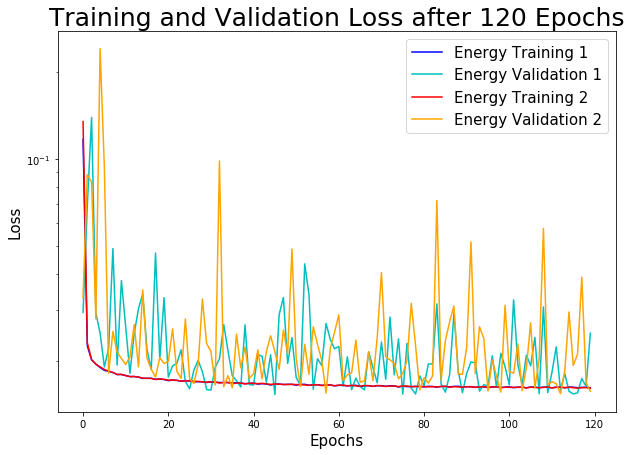

In [63]:
plt.figure(figsize=(10,7))
plt.plot(energy_loss1,'b',label="Energy Training 1")
plt.plot(val_energy_loss1,'c',label="Energy Validation 1")
#plt.plot(zenith_loss1,'r',label="Zenith Training 1")
#plt.plot(val_zenith_loss1,'m',label="Zenith Validation 1")

plt.plot(energy_loss2,'r',label="Energy Training 2")
plt.plot(val_energy_loss2,'orange',label="Energy Validation 2")
#plt.plot(zenith_loss2,'pink',label="Zenith Training 2")
#plt.plot(val_zenith_loss2,'purple',label="Zenith Validation 2")

plt.yscale('log')

plt.title("Energy Training and Validation Loss after %s Epochs"%len(loss1),fontsize=25)

plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.legend(fontsize=15)

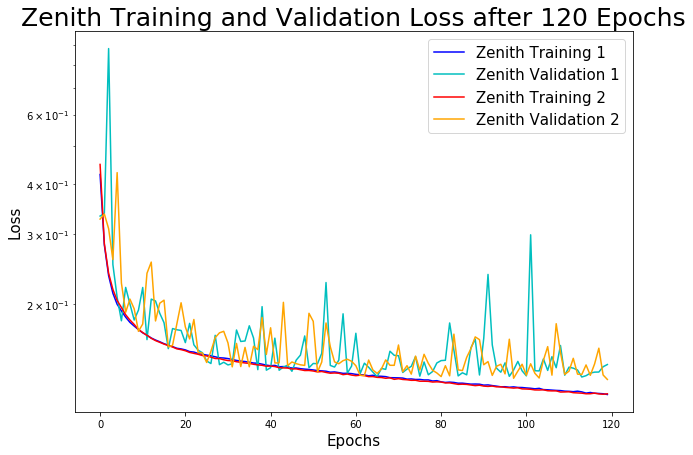

In [65]:
plt.figure(figsize=(10,7))
#plt.plot(energy_loss1,'b',label="Energy Training 1")
#plt.plot(val_energy_loss1,'c',label="Energy Validation 1")
plt.plot(zenith_loss1,'b',label="Zenith Training 1")
plt.plot(val_zenith_loss1,'c',label="Zenith Validation 1")

#plt.plot(energy_loss2,'r',label="Energy Training 2")
#plt.plot(val_energy_loss2,'orange',label="Energy Validation 2")
plt.plot(zenith_loss2,'r',label="Zenith Training 2")
plt.plot(val_zenith_loss2,'orange',label="Zenith Validation 2")

plt.yscale('log')

plt.title("Zenith Training and Validation Loss after %s Epochs"%len(loss1),fontsize=25)

plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.legend(fontsize=15)